## Machine learning completion of the project: The SECOM data set

* The SECOM data set contains 1567 examples that originate from a production line for wafer manufacture. 
* Each example is a vector of 590 sensor measurements plus an identification of the pass / fail test. 
* Among the 1567 examples, there are only 104 failed cases marked positive (coded as 1), while a much larger number of examples pass the test and are marked negative (coded as -1). 
* The imbalance between passed and failed examples, as well as the large amount of measurement data obtained from hundreds of sensors, make it difficult to analyze this data set precisely.

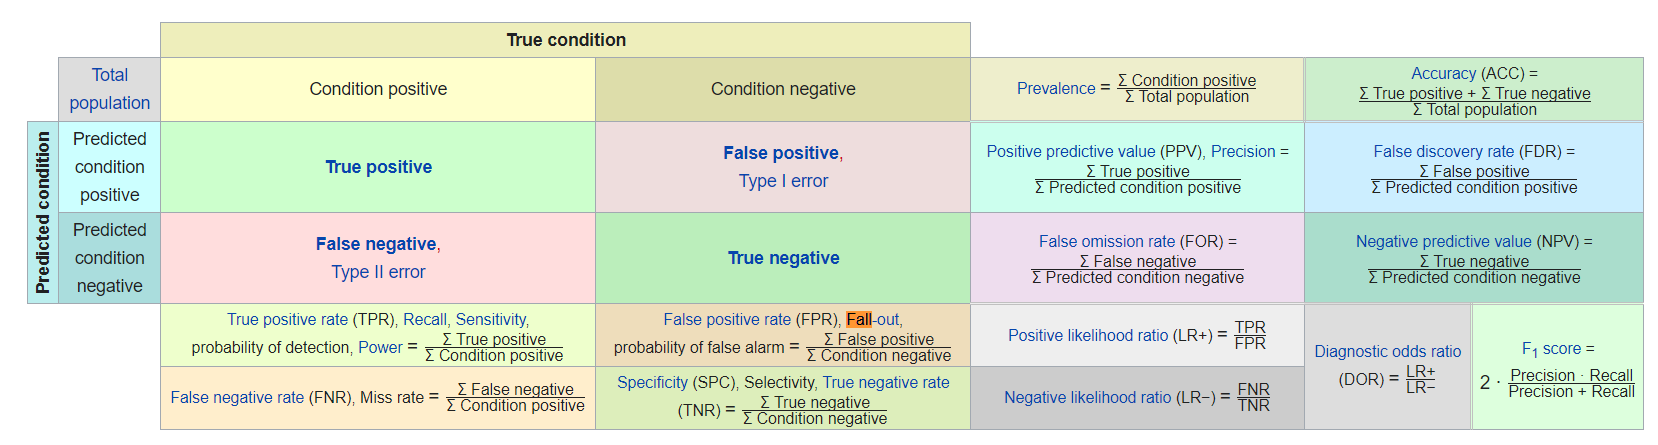

### Import and Load

In [1]:
# for basic operations
import numpy as np 
import pandas as pd 

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
# plt.style.use('fivethirtyeight')

# for modeling 
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
# from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import OneClassSVM

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

In [2]:
data = pd.read_csv("uci-secom.csv")
data

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass_Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2008-10-16 15:13:00,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,...,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720,-1
1563,2008-10-16 20:49:00,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,...,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720,-1
1564,2008-10-17 05:26:00,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,...,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231,-1
1565,2008-10-17 06:01:00,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,...,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941,-1


## Data Cleaning

In [3]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

display(summary(data).sort_values(by='Nulls', ascending=False))

Data shape: (1567, 592)
___________________________
Data Types:
float64    590
int64        1
object       1
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
292,float64,138,93,1429,0.0041,0.0831
158,float64,138,139,1429,234.1,2505.3
157,float64,138,129,1429,0.0118,0.2876
293,float64,138,139,1429,82.3233,879.226
358,float64,226,21,1341,0.0017,0.0047
...,...,...,...,...,...,...
429,float64,1567,1542,0,0.7837,186.616
250,float64,1567,1566,0,21.0107,1119.7
251,float64,1567,143,0,0.0003,0.9909
252,float64,1567,1533,0,0.7673,2549.99


### Missing Values

In [4]:
def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

In [5]:
df_na = null_values(data)
df_na

,Missing_Records,Percentage (%)
292,1429,91.193363
293,1429,91.193363
157,1429,91.193363
158,1429,91.193363
358,1341,85.577537
...,...,...
456,1,0.063816
218,1,0.063816
356,1,0.063816
457,1,0.063816


In [6]:
df_na = df_na[df_na["Percentage (%)"] > 50]
df_na

,Missing_Records,Percentage (%)
292,1429,91.193363
293,1429,91.193363
157,1429,91.193363
158,1429,91.193363
358,1341,85.577537
85,1341,85.577537
492,1341,85.577537
220,1341,85.577537
518,1018,64.964901
246,1018,64.964901


In [7]:
df_na.shape

(28, 2)

#### There are 28 columns that contain more than 50% NAs. These must be removed.

In [8]:
df_na.index

Index(['292', '293', '157', '158', '358', '85', '492', '220', '518', '246',
       '245', '516', '517', '110', '384', '382', '383', '109', '244', '111',
       '580', '578', '581', '579', '73', '72', '345', '346'],
      dtype='object')

In [9]:
data = data.drop(axis=1, columns=df_na.index)
data.shape

(1567, 564)

#### 28 columns with more than 50% NAs were removed

In [10]:
data.head()

,Time,0,1,2,3,4,5,6,7,8,...,577,582,583,584,585,586,587,588,589,Pass_Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,14.9509,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


#### Missing values must be fill

In [11]:
#strategy 1: latest information available
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)
data

,Time,0,1,2,3,4,5,6,7,8,...,577,582,583,584,585,586,587,588,589,Pass_Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,14.9509,0.5005,0.0118,0.0035,2.3630,0.0096,0.0201,0.0060,208.2045,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2008-10-16 15:13:00,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,...,11.7256,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720,-1
1563,2008-10-16 20:49:00,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,...,17.8379,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720,-1
1564,2008-10-17 05:26:00,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,1.4333,...,17.7267,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231,-1
1565,2008-10-17 06:01:00,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,...,19.2104,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941,-1


Now we have a cleaner data set. No NaN values.

In [12]:
null_values(data)

,Missing_Records,Percentage (%)


In [13]:
data.shape

(1567, 564)

### Unique values in columns

In [14]:
data["5"].nunique()

1

In [15]:
def unique_columns(df):
    """a function to show unique columns with column name"""
    uni_col_list = []
    for column in df.columns:
        if df[column].nunique() == 1:
            uni_col_list.append(column)
    return uni_col_list

In [16]:
len(unique_columns(data))

116

#### There are 116 columns that contain unique values. These columns must be removed.  

In [17]:
data["179"].nunique()

1

In [18]:
data.shape

(1567, 564)

In [19]:
data = data.drop(axis=1, columns=unique_columns(data))
data.shape

(1567, 448)

In [20]:
# We will not use the "Time" column in the following steps, so this column can be completely deleted.
data.drop(columns="Time", axis=1, inplace=True)
data.shape

(1567, 447)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 447 entries, 0 to Pass_Fail
dtypes: float64(446), int64(1)
memory usage: 5.3 MB


#### We now have cleaner records than before. All values are metric and not NA values.
- We have 1567 rows and 447 columns before modeling

### EDA (Exploratory Data Analysis)

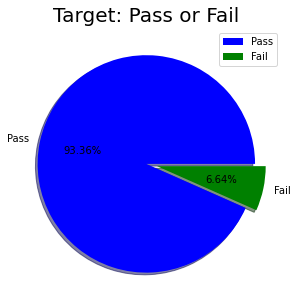

-1    1463
 1     104
Name: Pass_Fail, dtype: int64

In [22]:
# pie chart
# We have highly imbalanced class with only 6.6% failures and 93.4% pass

plt.rcParams['figure.figsize'] = (5,5)
labels = ['Pass', 'Fail']
size = data['Pass_Fail'].value_counts()
colors = ['blue', 'green']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()
data.Pass_Fail.value_counts()

**There is unbalanced record. The Failing Values are only 104. Data balancing must be applied**

In [23]:
data.corr()["Pass_Fail"].sort_values()

28          -0.107685
316         -0.089071
125         -0.083460
26          -0.082052
180         -0.078530
               ...   
348          0.129593
510          0.131574
103          0.149118
59           0.155991
Pass_Fail    1.000000
Name: Pass_Fail, Length: 447, dtype: float64

**Neither column has a great correlation with Pass_Fail**

## Data Cleaning/Preprocessing

In [24]:
# Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [25]:
#Remove columns having more than 70% correlation
#Both positive and negative correlations are considered here
data = remove_collinear_features(data,0.70)

17 | 11 | 0.79
22 | 21 | 0.73
26 | 25 | 0.82
27 | 25 | 0.98
27 | 26 | 0.79
30 | 29 | 0.86
34 | 32 | 0.75
35 | 34 | 0.77
36 | 32 | 0.75
36 | 34 | 1.0
36 | 35 | 0.77
39 | 34 | 0.8
39 | 36 | 0.8
46 | 45 | 0.81
50 | 46 | 0.9
51 | 47 | 0.71
54 | 53 | 0.94
60 | 43 | 0.89
65 | 64 | 0.84
66 | 46 | 0.82
66 | 50 | 0.76
70 | 46 | 0.8
70 | 50 | 0.77
70 | 62 | 0.73
70 | 66 | 0.9
96 | 94 | 0.96
98 | 94 | 0.84
98 | 96 | 0.87
101 | 94 | 0.73
101 | 96 | 0.79
101 | 98 | 0.91
104 | 99 | 0.99
105 | 92 | 0.99
106 | 93 | 0.99
123 | 121 | 0.94
124 | 121 | 0.89
124 | 123 | 0.86
125 | 122 | 0.71
127 | 122 | 0.96
130 | 122 | 0.83
130 | 127 | 0.79
140 | 4 | 1.0
147 | 16 | 0.89
148 | 16 | 0.97
148 | 147 | 0.89
152 | 16 | 0.98
152 | 147 | 0.9
152 | 148 | 0.99
154 | 16 | 0.87
154 | 147 | 0.8
154 | 148 | 0.94
154 | 152 | 0.89
155 | 19 | 0.8
163 | 26 | 0.71
163 | 159 | 0.76
164 | 26 | 0.77
164 | 159 | 0.8
164 | 163 | 0.92
165 | 26 | 0.74
165 | 159 | 0.79
165 | 163 | 0.9
165 | 164 | 0.96
174 | 172 | 1.0
185 | 184 | 0.

439 | 168 | 0.79
439 | 303 | 0.77
440 | 27 | 0.71
440 | 169 | 1.0
440 | 304 | 0.98
441 | 170 | 0.99
441 | 305 | 0.95
442 | 171 | 0.97
442 | 306 | 0.96
443 | 172 | 1.0
443 | 174 | 1.0
443 | 307 | 0.96
443 | 309 | 0.96
444 | 173 | 0.99
444 | 308 | 0.95
445 | 172 | 1.0
445 | 174 | 1.0
445 | 307 | 0.96
445 | 309 | 0.96
445 | 443 | 0.99
446 | 175 | 1.0
446 | 310 | 0.95
447 | 176 | 1.0
447 | 311 | 0.98
448 | 177 | 1.0
448 | 312 | 1.0
452 | 180 | 0.99
452 | 316 | 0.86
453 | 181 | 1.0
453 | 317 | 0.96
454 | 182 | 0.99
454 | 318 | 0.97
455 | 183 | 1.0
455 | 319 | 0.98
456 | 184 | 0.97
456 | 185 | 0.71
456 | 320 | 0.96
456 | 321 | 0.72
457 | 185 | 1.0
457 | 187 | 0.81
457 | 320 | 0.7
457 | 321 | 0.99
457 | 323 | 0.8
457 | 456 | 0.71
459 | 185 | 0.82
459 | 187 | 1.0
459 | 321 | 0.82
459 | 323 | 0.99
459 | 457 | 0.8
467 | 195 | 1.0
467 | 331 | 0.95
469 | 67 | 0.87
469 | 196 | 0.9
469 | 197 | 1.0
469 | 198 | 0.72
469 | 199 | 0.83
469 | 203 | 0.71
469 | 204 | 0.81
469 | 205 | 0.85
469 | 207 | 0.88
4

In [26]:
data.shape

(1567, 205)

## Iteration 1: (Unbalanced data)

### Split data

In [27]:
# from sklearn.model_selection import train_test_split

In [28]:
# separating the dependent and independent data
X = data.drop('Pass_Fail', axis=1)
y = data['Pass_Fail']

# getting the shapes of new data sets x and y
print("shape of X:", X.shape)
print("shape of y:", y.shape)

shape of X: (1567, 204)
shape of y: (1567,)


In [29]:
# the function train_test_split creates random data samples (default: 75-25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)  # seed for comparable results

In [30]:
# gettiing the shapes
print("shape of X_train: ", X_train.shape)
print("shape of X_test: ", X_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of X_train:  (1175, 204)
shape of X_test:  (392, 204)
shape of y_train:  (1175,)
shape of y_test:  (392,)


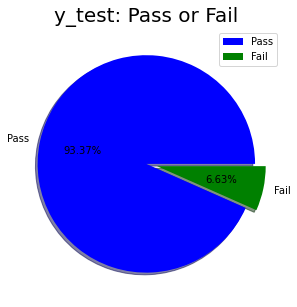

In [31]:
# Let's check if the pass / fail ratio is preserved in y_test data.
size = y_test.value_counts()
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('y_test: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()

### Data Scaling

In [32]:
# standardization
# from sklearn.preprocessing import StandardScaler

# creating a standard scaler
sc = StandardScaler()

# fitting independent data to the model
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**Lazy Predict**

In [33]:
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.utils.testing import ignore_warnings

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit (X_train, X_test, y_train, y_test)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.80,0.68,0.68,0.84,0.03
GaussianNB,0.39,0.62,0.62,0.50,0.04
BernoulliNB,0.87,0.59,0.59,0.88,0.03
BaggingClassifier,0.93,0.59,0.59,0.92,2.14
AdaBoostClassifier,0.93,0.59,0.59,0.91,0.84
DecisionTreeClassifier,0.88,0.54,0.54,0.88,0.40
LinearDiscriminantAnalysis,0.91,0.54,0.54,0.90,0.13
KNeighborsClassifier,0.93,0.54,0.54,0.91,0.32
SGDClassifier,0.85,0.53,0.53,0.87,0.06


### Use algorithms

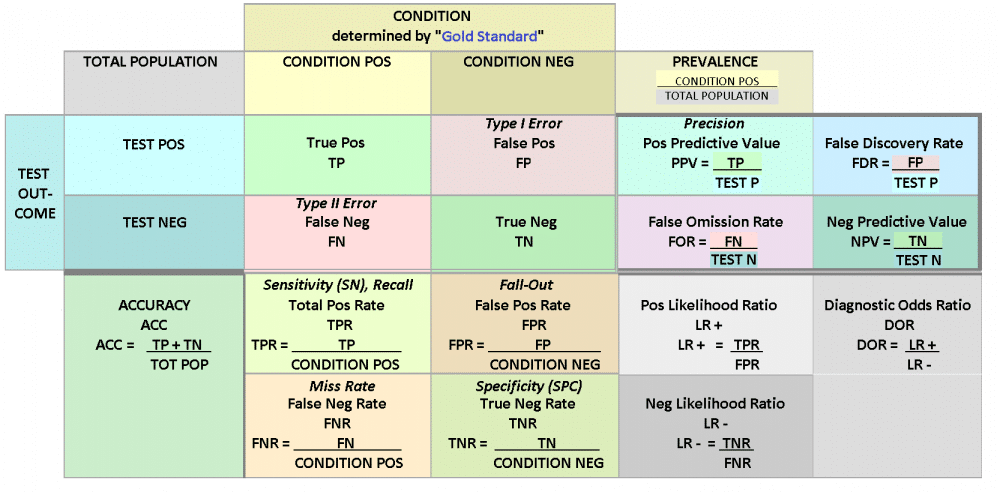

In [34]:
cv_acc = {}
cv_TPR = {}
cv_FPR = {}

In [35]:
def plot_result(model, name:str):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores = cross_val_score(model, X_test, y_test, cv=10, scoring = 'balanced_accuracy')
    cv_acc[name] = round(scores.mean(), 4)*100  # balanced accuracy
    cv_TPR[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (Max)
    cv_FPR[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (Min)
    print('Average Balanced Accuracy (CV=10):', scores.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot Confusion Matrix
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()

##### 1-Decision tree

In [36]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

Average Balanced Accuracy (CV=10): 0.578003003003003
              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



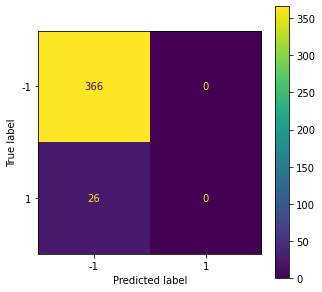

In [37]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)
plot_result(dtc, "dtc")

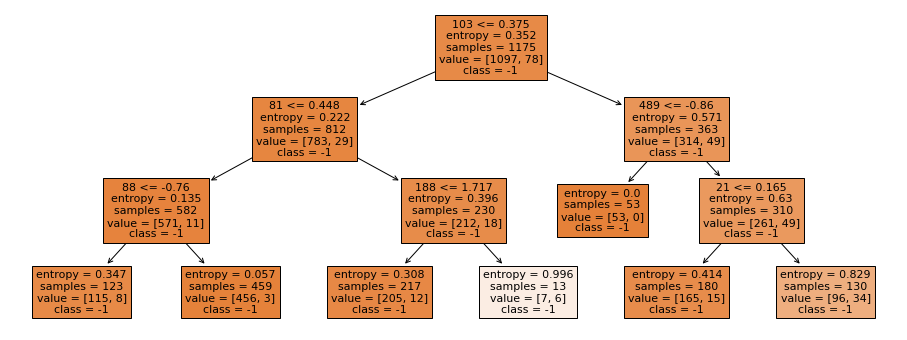

In [38]:
# plot tree
plt.figure(figsize=(16,6))
plot_tree(dtc, filled = True, class_names=["-1", "1"], feature_names=X.columns, fontsize=11);

In [39]:
cv_acc

{'dtc': 57.8}

In [40]:
cv_FPR

{'dtc': 0.0}

In [41]:
cv_TPR

{'dtc': 0.0}

##### 2-Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

Average Balanced Accuracy (CV=10): 0.5058558558558558
              precision    recall  f1-score   support

          -1       0.94      0.92      0.93       366
           1       0.09      0.12      0.10        26

    accuracy                           0.86       392
   macro avg       0.51      0.52      0.51       392
weighted avg       0.88      0.86      0.87       392



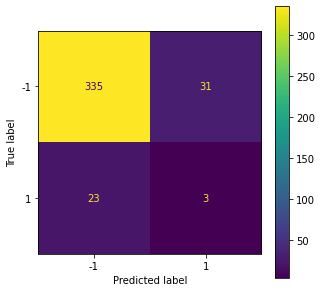

In [43]:
lr = LogisticRegression(max_iter=150)
plot_result(lr, "lr")

##### 3-SVM

In [44]:
from sklearn.svm import SVC

Average Balanced Accuracy (CV=10): 0.5
              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



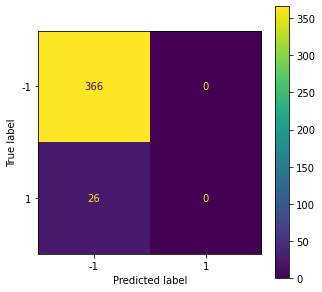

In [45]:
svc = SVC(C=1.0, kernel='rbf', gamma='scale')  # default values
plot_result(svc, "svc")

##### 4-Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

Average Balanced Accuracy (CV=10): 0.5
              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



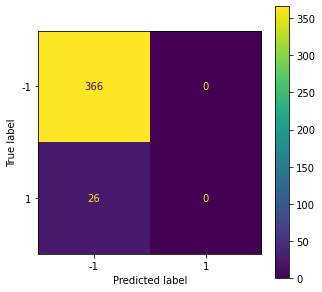

In [47]:
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None)
plot_result(rfc, "rfc")

In [48]:
def plot_feature_importances(model):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:10]

    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()

    print(f"Top 10 Feature Importance for {str(model).split('(')[0]}\n\n",feature_imp[:10],sep='')

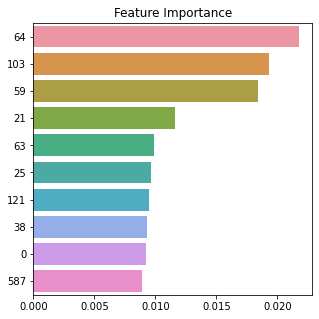

Top 10 Feature Importance for RandomForestClassifier

64    0.02
103   0.02
59    0.02
21    0.01
63    0.01
25    0.01
121   0.01
38    0.01
0     0.01
587   0.01
dtype: float64


In [49]:
plot_feature_importances(rfc)

##### 5-Gradient Boosting

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

Average Balanced Accuracy (CV=10): 0.6336336336336336
              precision    recall  f1-score   support

          -1       0.94      0.93      0.94       366
           1       0.18      0.23      0.20        26

    accuracy                           0.88       392
   macro avg       0.56      0.58      0.57       392
weighted avg       0.89      0.88      0.89       392



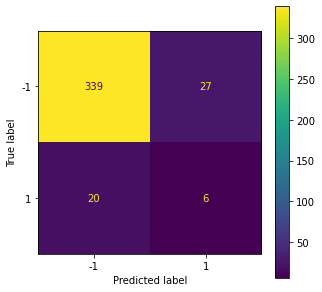

In [51]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=3, random_state=42)
plot_result(gbc, "gbc")

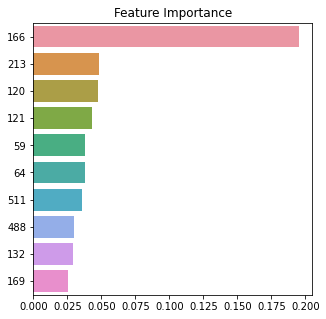

Top 10 Feature Importance for GradientBoostingClassifier

166   0.20
213   0.05
120   0.05
121   0.04
59    0.04
64    0.04
511   0.04
488   0.03
132   0.03
169   0.03
dtype: float64


In [52]:
plot_feature_importances(gbc)

##### 6-Naive Bayes

In [53]:
from sklearn.naive_bayes import GaussianNB

Average Balanced Accuracy (CV=10): 0.5826576576576576
              precision    recall  f1-score   support

          -1       0.98      0.36      0.52       366
           1       0.09      0.88      0.16        26

    accuracy                           0.39       392
   macro avg       0.53      0.62      0.34       392
weighted avg       0.92      0.39      0.50       392



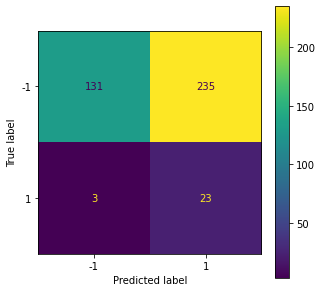

In [54]:
nb = GaussianNB()
plot_result(nb, "nb")

##### 7-kNN

In [55]:
from sklearn.neighbors import KNeighborsClassifier

Average Balanced Accuracy (CV=10): 0.544557057057057
              precision    recall  f1-score   support

          -1       0.94      0.98      0.96       366
           1       0.25      0.08      0.12        26

    accuracy                           0.92       392
   macro avg       0.59      0.53      0.54       392
weighted avg       0.89      0.92      0.90       392



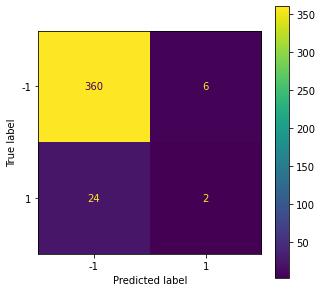

In [56]:
knn = KNeighborsClassifier(n_neighbors=3)
plot_result(knn, "knn")

**8-XGBOOST**

In [57]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

Average Balanced Accuracy (CV=10): 0.4986486486486486
              precision    recall  f1-score   support

          -1       0.94      1.00      0.97       366
           1       0.50      0.04      0.07        26

    accuracy                           0.93       392
   macro avg       0.72      0.52      0.52       392
weighted avg       0.91      0.93      0.91       392



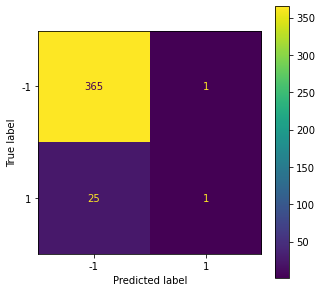

In [58]:
xgb = XGBClassifier(eval_metric = "logloss")
plot_result(xgb, "xgb")

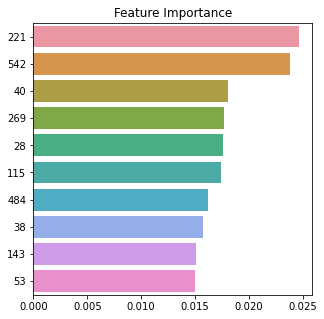

Top 10 Feature Importance for XGBClassifier

221   0.02
542   0.02
40    0.02
269   0.02
28    0.02
115   0.02
484   0.02
38    0.02
143   0.02
53    0.02
dtype: float32


In [59]:
plot_feature_importances(xgb)

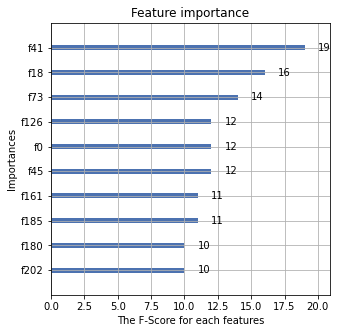

In [60]:
from xgboost import plot_importance
plot_importance(xgb,max_num_features=10)
plt.xlabel('The F-Score for each features')
plt.ylabel('Importances')
plt.show()

### Evaluation (iteration 1)

In [61]:
cv_acc

{'dtc': 57.8,
 'lr': 50.59,
 'svc': 50.0,
 'rfc': 50.0,
 'gbc': 63.36000000000001,
 'nb': 58.269999999999996,
 'knn': 54.459999999999994,
 'xgb': 49.86}

In [62]:
cv_TPR

{'dtc': 0.0,
 'lr': 11.538461538461538,
 'svc': 0.0,
 'rfc': 0.0,
 'gbc': 23.076923076923077,
 'nb': 88.46153846153845,
 'knn': 7.6923076923076925,
 'xgb': 3.8461538461538463}

In [63]:
cv_FPR

{'dtc': 0.0,
 'lr': 8.469945355191257,
 'svc': 0.0,
 'rfc': 0.0,
 'gbc': 7.377049180327869,
 'nb': 64.20765027322405,
 'knn': 1.639344262295082,
 'xgb': 0.273224043715847}

In [64]:
cv_FPR.values()

dict_values([0.0, 8.469945355191257, 0.0, 0.0, 7.377049180327869, 64.20765027322405, 1.639344262295082, 0.273224043715847])

In [65]:
df_eval = pd.DataFrame(data={'model': list(cv_acc.keys()), 'bal_acc': list(cv_acc.values()), 'recall': list(cv_TPR.values()), 'fallout':list(cv_FPR.values())})
df_eval

,model,bal_acc,recall,fallout
0,dtc,57.80,0.00,0.00
1,lr,50.59,11.54,8.47
2,svc,50.00,0.00,0.00
3,rfc,50.00,0.00,0.00
4,gbc,63.36,23.08,7.38
5,nb,58.27,88.46,64.21
6,knn,54.46,7.69,1.64
7,xgb,49.86,3.85,0.27


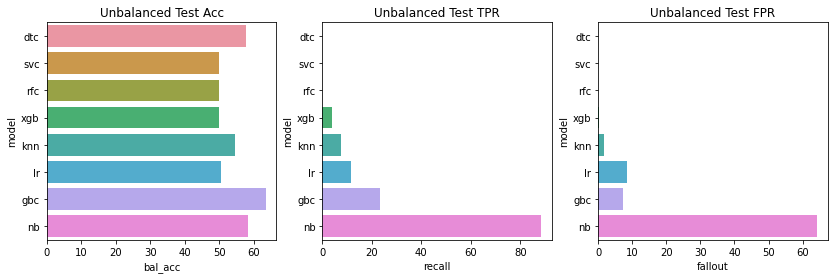

In [66]:
fig, ax = plt.subplots(1,3, figsize=(14, 4))
sns.barplot(x="bal_acc", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0])
ax[0].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[1])
ax[1].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[2])
ax[2].set_title("Unbalanced Test FPR")
plt.show()

NaiveBayes gave high BalanceAccuracy and TPR_Score (Recall), but it gave the poor FPR_Score (Fallout) in this unbalanced data set.

## Iteration 2: (with SMOTE)

### Balancing data

In [67]:
y_test.value_counts(normalize=True)

-1   0.93
 1   0.07
Name: Pass_Fail, dtype: float64

In [68]:
y_train.value_counts(normalize=True)

-1   0.93
 1   0.07
Name: Pass_Fail, dtype: float64

In [69]:
# pip install imblearn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [70]:
oversmote = SMOTE()
X_train_os, y_train_os= oversmote.fit_resample(X_train, y_train)

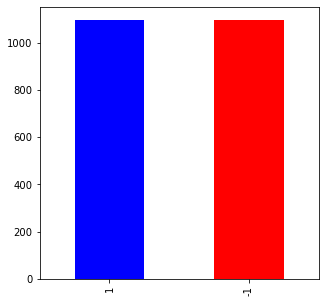

In [71]:
y_train_os.value_counts().plot.bar(color=["blue", "red"])
plt.show()

In [72]:
X_train_os.shape

(2194, 204)

### Use algorithms

In [73]:
cv_acc_balance = {}
cv_TPR_balance = {}
cv_FPR_balance = {}

In [74]:
def plot_result_smote(model, name:str):
    model.fit(X_train_os, y_train_os)
    y_pred = model.predict(X_test)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores = cross_val_score(model, X_test, y_test, cv=10, scoring = 'balanced_accuracy')
    cv_acc_balance[name] = round(scores.mean(), 4)*100  # balanced accuracy
    cv_TPR_balance[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (maximieren)
    cv_FPR_balance[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (minimieren)
    print('Average Balanced Accuracy (CV=10):', scores.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot Confusion Matrix
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()

Average Balanced Accuracy (CV=10): 0.6002627627627628
              precision    recall  f1-score   support

          -1       0.96      0.89      0.92       366
           1       0.21      0.42      0.28        26

    accuracy                           0.86       392
   macro avg       0.58      0.66      0.60       392
weighted avg       0.91      0.86      0.88       392



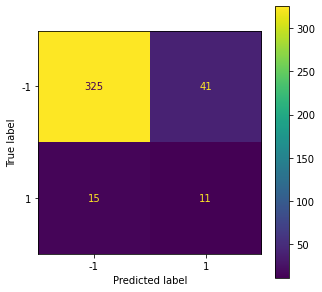

In [75]:
# Decision tree
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)

plot_result_smote(dtc, "dtc")

Average Balanced Accuracy (CV=10): 0.5058558558558558
              precision    recall  f1-score   support

          -1       0.94      0.85      0.89       366
           1       0.08      0.19      0.11        26

    accuracy                           0.80       392
   macro avg       0.51      0.52      0.50       392
weighted avg       0.88      0.80      0.84       392



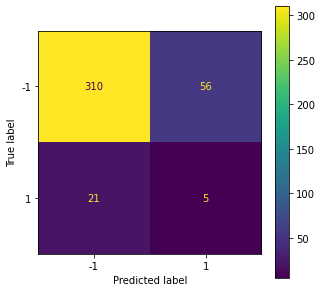

In [76]:
# Logistic Regression
lr = LogisticRegression(max_iter=200)
plot_result_smote(lr, "lr")

Average Balanced Accuracy (CV=10): 0.5
              precision    recall  f1-score   support

          -1       0.93      0.99      0.96       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



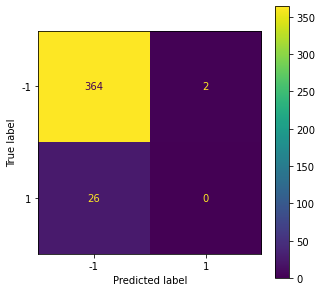

In [77]:
# SVC
svc = SVC(C=1.0, kernel='rbf', gamma='scale')  # default Werte
plot_result_smote(svc, "svc")

Average Balanced Accuracy (CV=10): 0.5
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



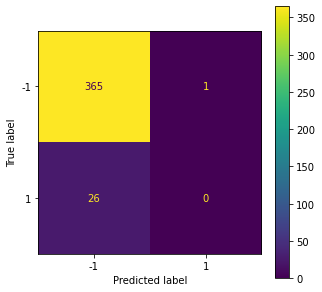

In [78]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None)
plot_result_smote(rfc, "rfc")

Average Balanced Accuracy (CV=10): 0.6336336336336336
              precision    recall  f1-score   support

          -1       0.94      0.96      0.95       366
           1       0.25      0.19      0.22        26

    accuracy                           0.91       392
   macro avg       0.60      0.58      0.58       392
weighted avg       0.90      0.91      0.90       392



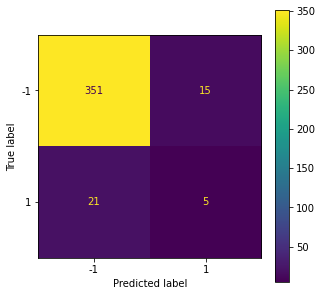

In [79]:
# Gradient Boost
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=3, random_state=42)
plot_result_smote(gbc, "gbc")

Average Balanced Accuracy (CV=10): 0.5826576576576576
              precision    recall  f1-score   support

          -1       0.97      0.49      0.65       366
           1       0.10      0.77      0.17        26

    accuracy                           0.51       392
   macro avg       0.53      0.63      0.41       392
weighted avg       0.91      0.51      0.62       392



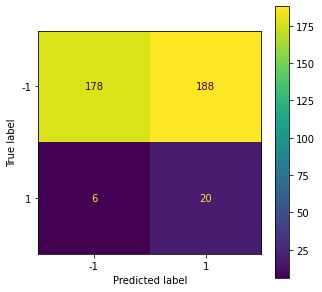

In [80]:
# Naive Bayes
nb = GaussianNB()
plot_result_smote(nb, "nb")

Average Balanced Accuracy (CV=10): 0.544557057057057
              precision    recall  f1-score   support

          -1       0.96      0.32      0.48       366
           1       0.08      0.81      0.14        26

    accuracy                           0.35       392
   macro avg       0.52      0.57      0.31       392
weighted avg       0.90      0.35      0.46       392



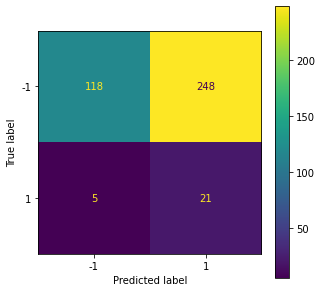

In [81]:
# kNN
knn = KNeighborsClassifier(n_neighbors=3)
plot_result_smote(knn, "knn")

Average Balanced Accuracy (CV=10): 0.5125
              precision    recall  f1-score   support

          -1       0.95      0.90      0.93       366
           1       0.19      0.31      0.23        26

    accuracy                           0.86       392
   macro avg       0.57      0.61      0.58       392
weighted avg       0.90      0.86      0.88       392



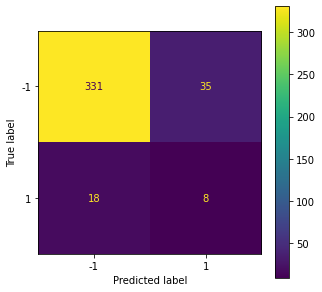

In [82]:
# XGBOOST
xgb = XGBClassifier(eval_metric = "logloss",n_estimators=25, learning_rate=0.01,  max_depth=3, random_state=42)
plot_result_smote(xgb, "xgb")

In [83]:
cv_acc

{'dtc': 57.8,
 'lr': 50.59,
 'svc': 50.0,
 'rfc': 50.0,
 'gbc': 63.36000000000001,
 'nb': 58.269999999999996,
 'knn': 54.459999999999994,
 'xgb': 49.86}

In [84]:
df_eval_smote = pd.DataFrame(data={'model': list(cv_acc_balance.keys()), 'bal_acc': list(cv_acc_balance.values()), 'recall': list(cv_TPR_balance.values()), 'fallout':list(cv_FPR_balance.values())})
df_eval_smote

,model,bal_acc,recall,fallout
0,dtc,60.03,42.31,11.20
1,lr,50.59,19.23,15.30
2,svc,50.00,0.00,0.55
3,rfc,50.00,0.00,0.27
4,gbc,63.36,19.23,4.10
5,nb,58.27,76.92,51.37
6,knn,54.46,80.77,67.76
7,xgb,51.25,30.77,9.56


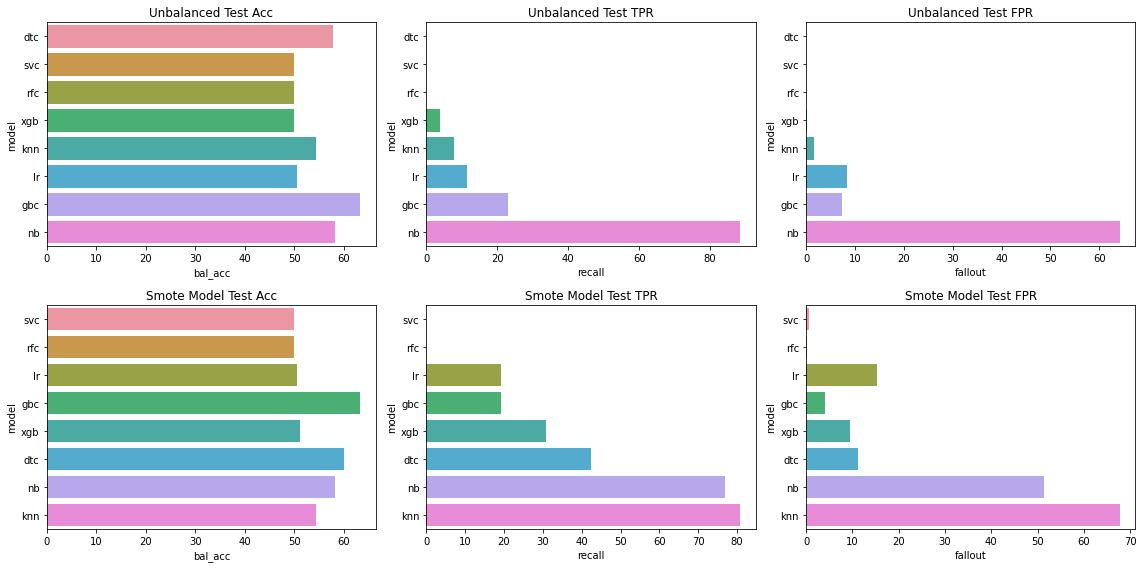

In [85]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))
sns.barplot(x="bal_acc", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,0])
ax[0,0].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,1])
ax[0,1].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,2])
ax[0,2].set_title("Unbalanced Test FPR")
sns.barplot(x="bal_acc", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,0])
ax[1,0].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,1])
ax[1,1].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,2])
ax[1,2].set_title("Smote Model Test FPR")
plt.tight_layout()
plt.show()

GradientBoosting yielded the optimized result as better FPR and relative mean strong recall scores. The balance accuracy is also relatively good.

## Iteration 3: (with SMOTE and Feature Selection Filter method)

In [86]:
from scipy.stats import pearsonr

In [87]:
df_filtered = pd.DataFrame(X_train_os).apply(lambda x: pd.Series(pearsonr(x, y_train_os), index=[0, 1]), axis =0).T.applymap(lambda x: np.round(x,3)).sort_values(by=1, ascending=False)
df_filtered

,0,1
178,-0.00,1.00
14,0.00,0.99
48,0.00,0.99
7,0.00,0.91
200,-0.00,0.91
...,...,...
146,0.12,0.00
85,0.19,0.00
86,-0.17,0.00
143,-0.10,0.00


In [88]:
df_filtered = df_filtered[df_filtered[1] <= 0.05]
df_filtered

,0,1
1,-0.04,0.04
32,-0.04,0.04
2,0.04,0.04
19,-0.04,0.04
180,0.04,0.04
...,...,...
146,0.12,0.00
85,0.19,0.00
86,-0.17,0.00
143,-0.10,0.00


In [89]:
df_filtered.index

Int64Index([  1,  32,   2,  19, 180, 161, 188, 164,  27,  59,
            ...
            151,  89, 150,  78,  79, 146,  85,  86, 143, 102],
           dtype='int64', length=130)

In [90]:
X_train_os_selected_filter = pd.DataFrame(X_train_os)[df_filtered.index]
X_test_fe = pd.DataFrame(X_test)[df_filtered.index]
X_train_os_selected_filter

,1,32,2,19,180,161,188,164,27,59,...,151,89,150,78,79,146,85,86,143,102
0,-0.35,-0.24,-0.52,0.12,-0.84,1.14,-1.40,-0.29,0.12,-1.44,...,0.06,1.07,-0.19,-0.08,-0.37,-0.65,-0.56,-1.32,0.45,-0.12
1,0.68,1.15,0.56,-1.75,2.19,2.87,0.15,-0.73,-1.08,0.09,...,-0.44,-0.29,0.08,-0.08,0.10,-1.29,0.67,1.04,-1.34,0.62
2,0.47,-0.94,1.33,0.05,1.43,0.01,-0.50,-0.83,-0.90,1.32,...,1.49,0.14,-0.53,-0.08,1.38,2.64,-0.56,-0.02,-1.03,-1.31
3,0.67,-0.07,-0.66,-0.08,-0.84,-0.52,0.55,-0.19,0.13,-0.62,...,-0.38,0.06,-0.66,-0.08,0.03,1.71,-0.36,0.07,1.21,-0.17
4,-0.39,0.35,0.77,1.59,-0.84,-1.12,-0.48,-0.20,0.00,-0.03,...,-0.39,0.49,1.15,-0.08,0.25,1.20,0.05,0.38,1.01,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,0.35,0.30,-0.63,-0.14,-0.29,0.77,-0.36,-0.41,-0.66,-0.31,...,-0.33,1.15,0.13,-0.08,-0.31,0.42,-0.10,-0.74,-0.59,-0.31
2190,0.07,1.05,1.31,-0.07,1.80,1.77,0.26,-0.52,1.22,-0.17,...,2.15,0.46,-1.41,-0.08,0.46,-0.38,0.14,-0.40,0.66,-0.12
2191,0.54,-0.40,-0.40,1.00,0.49,-0.56,-0.29,0.31,0.09,-0.16,...,-0.28,-0.72,0.95,-0.08,-1.36,1.03,-0.64,-0.39,-1.30,-0.55
2192,-0.22,-0.91,-0.43,-0.48,-0.84,-0.78,0.50,0.32,0.05,-0.03,...,0.61,1.02,-0.95,-0.08,-0.74,1.26,-0.24,-1.41,0.54,-0.46


#### Use Algorithm

In [91]:
cv_acc_balance_fe = {}
cv_TPR_balance_fe = {}
cv_FPR_balance_fe = {}

In [92]:
def plot_result_smoted_fe(model, name:str):
    model.fit(X_train_os_selected_filter, y_train_os)
    y_pred = model.predict(X_test_fe)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores = cross_val_score(model, X_test_fe, y_test, cv=10, scoring = 'balanced_accuracy')
    cv_acc_balance_fe[name] = round(scores.mean(), 4)*100  # balanced accuracy
    cv_TPR_balance_fe[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (maximize)
    cv_FPR_balance_fe[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (minimize)
    print('Average Balanced Accuracy (CV=10):', scores.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot Confusion Matrix
    plt.figure(figsize=(3,3))
    plot_confusion_matrix(model, X_test_fe, y_test)
    plt.show()

Average Balanced Accuracy (CV=10): 0.5170420420420421
              precision    recall  f1-score   support

          -1       0.96      0.89      0.92       366
           1       0.23      0.46      0.30        26

    accuracy                           0.86       392
   macro avg       0.59      0.67      0.61       392
weighted avg       0.91      0.86      0.88       392



<Figure size 216x216 with 0 Axes>

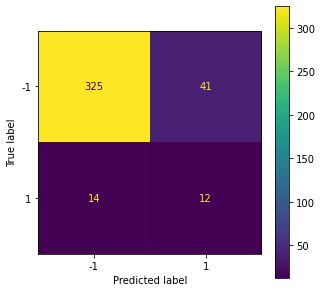

In [93]:
# Decision tree
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)

plot_result_smoted_fe(dtc, "dtc")

Average Balanced Accuracy (CV=10): 0.5475600600600601
              precision    recall  f1-score   support

          -1       0.94      0.84      0.89       366
           1       0.09      0.23      0.13        26

    accuracy                           0.80       392
   macro avg       0.52      0.53      0.51       392
weighted avg       0.88      0.80      0.84       392



<Figure size 216x216 with 0 Axes>

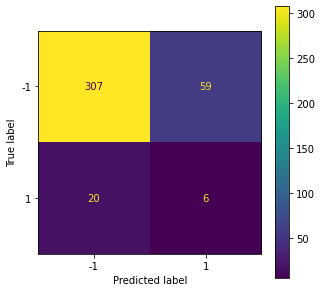

In [94]:
# Logistic Regression
lr = LogisticRegression(max_iter=200)
plot_result_smoted_fe(lr, "lr")

Average Balanced Accuracy (CV=10): 0.5
              precision    recall  f1-score   support

          -1       0.93      0.99      0.96       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



<Figure size 216x216 with 0 Axes>

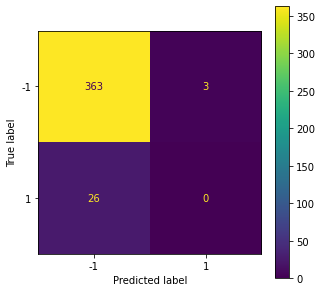

In [95]:
# SVC
svc = SVC(C=1.0, kernel='rbf', gamma='scale')  # default Werte
plot_result_smoted_fe(svc, "svc")

Average Balanced Accuracy (CV=10): 0.5
              precision    recall  f1-score   support

          -1       0.93      0.99      0.96       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



<Figure size 216x216 with 0 Axes>

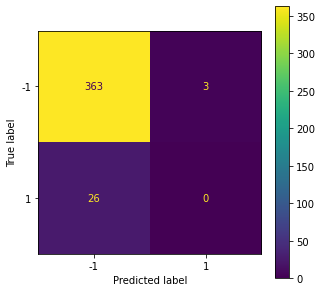

In [96]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None)
plot_result_smoted_fe(rfc, "rfc")

Average Balanced Accuracy (CV=10): 0.5336336336336337
              precision    recall  f1-score   support

          -1       0.94      0.95      0.94       366
           1       0.13      0.12      0.12        26

    accuracy                           0.89       392
   macro avg       0.53      0.53      0.53       392
weighted avg       0.88      0.89      0.89       392



<Figure size 216x216 with 0 Axes>

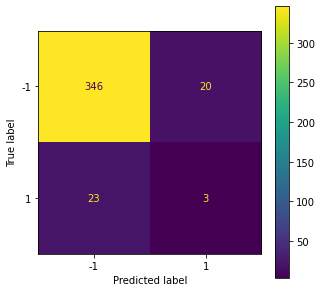

In [97]:
# Gradient Boost
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=3, random_state=42)
plot_result_smoted_fe(gbc, "gbc")

Average Balanced Accuracy (CV=10): 0.629954954954955
              precision    recall  f1-score   support

          -1       0.95      0.81      0.88       366
           1       0.14      0.42      0.21        26

    accuracy                           0.79       392
   macro avg       0.55      0.62      0.54       392
weighted avg       0.90      0.79      0.83       392



<Figure size 216x216 with 0 Axes>

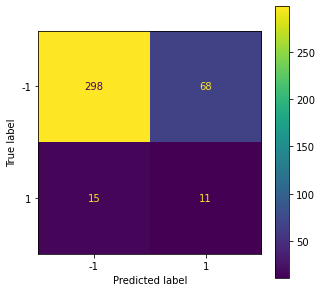

In [98]:
# Naive Bayes
nb = GaussianNB()
plot_result_smoted_fe(nb, "nb")

Average Balanced Accuracy (CV=10): 0.5278903903903904
              precision    recall  f1-score   support

          -1       0.99      0.37      0.54       366
           1       0.09      0.92      0.17        26

    accuracy                           0.41       392
   macro avg       0.54      0.65      0.35       392
weighted avg       0.93      0.41      0.51       392



<Figure size 216x216 with 0 Axes>

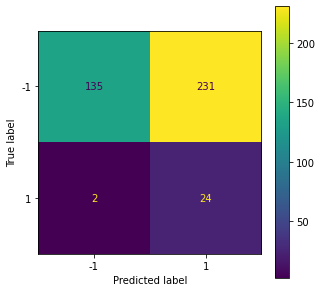

In [99]:
# kNN
knn = KNeighborsClassifier(n_neighbors=3)
plot_result_smoted_fe(knn, "knn")

Average Balanced Accuracy (CV=10): 0.5070945945945946
              precision    recall  f1-score   support

          -1       0.95      0.90      0.93       366
           1       0.19      0.31      0.23        26

    accuracy                           0.86       392
   macro avg       0.57      0.61      0.58       392
weighted avg       0.90      0.86      0.88       392



<Figure size 216x216 with 0 Axes>

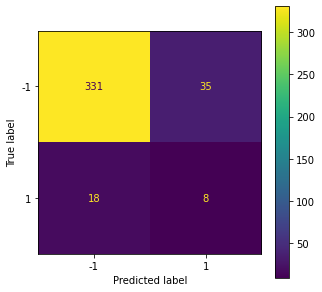

In [100]:
# XGBOOST
xgb = XGBClassifier(eval_metric = "logloss",n_estimators=25, learning_rate=0.01,  max_depth=3, random_state=42)
plot_result_smoted_fe(xgb, "xgb");

In [101]:
df_eval_smote_fe = pd.DataFrame(data={'model': list(cv_acc_balance.keys()), 'bal_acc': list(cv_acc_balance.values()), 'recall': list(cv_TPR_balance.values()), 'fallout':list(cv_FPR_balance.values())})
df_eval_smote_fe

,model,bal_acc,recall,fallout
0,dtc,60.03,42.31,11.20
1,lr,50.59,19.23,15.30
2,svc,50.00,0.00,0.55
3,rfc,50.00,0.00,0.27
4,gbc,63.36,19.23,4.10
5,nb,58.27,76.92,51.37
6,knn,54.46,80.77,67.76
7,xgb,51.25,30.77,9.56


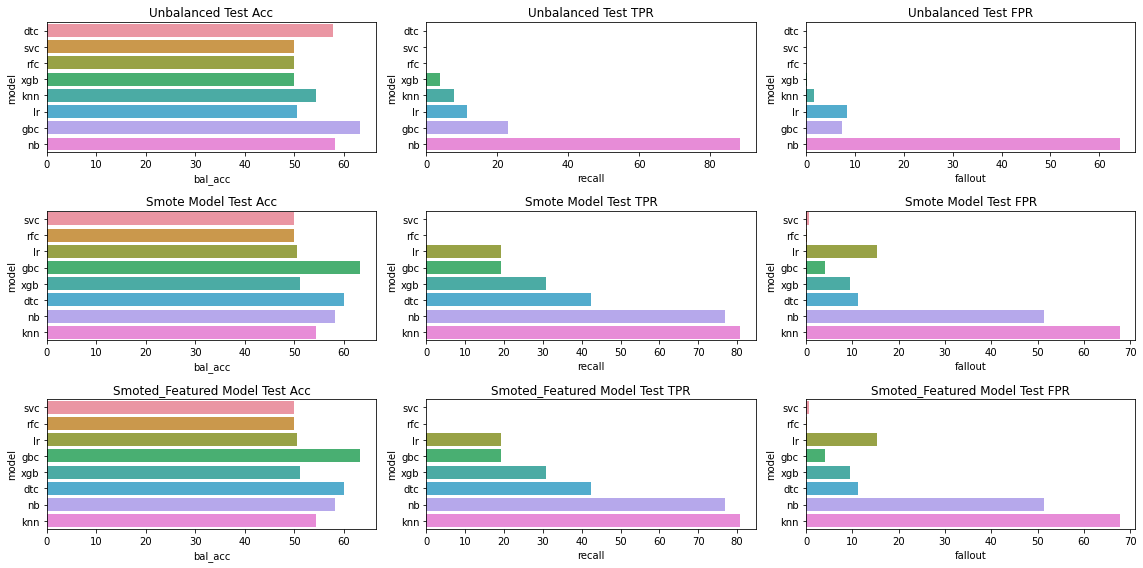

In [102]:
fig, ax = plt.subplots(3,3, figsize=(16, 8))
sns.barplot(x="bal_acc", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,0])
ax[0,0].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,1])
ax[0,1].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,2])
ax[0,2].set_title("Unbalanced Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,0])
ax[1,0].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,1])
ax[1,1].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,2])
ax[1,2].set_title("Smote Model Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,0])
ax[2,0].set_title("Smoted_Featured Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,1])
ax[2,1].set_title("Smoted_Featured Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,2])
ax[2,2].set_title("Smoted_Featured Model Test FPR")

plt.tight_layout()
plt.show()

According to Smote and Feature Selection with Pearson Correlation, nb gave the better result for recall and fallout.

## Iteration 4: (with SMOTE and PCA)

In [103]:
from sklearn.decomposition import PCA

In [104]:
X_train_os

array([[ 0.60276538, -0.35447884, -0.52058033, ..., -0.17639514,
        -0.5075407 , -0.38939963],
       [-0.0167734 ,  0.67593524,  0.55821396, ..., -0.84666272,
        -1.12816505, -0.38688076],
       [ 0.26887065,  0.47227047,  1.32658249, ...,  0.19065615,
        -0.92526863, -0.67370577],
       ...,
       [ 0.26408804,  0.53762746, -0.40164556, ...,  0.49831714,
         0.43357283, -0.2909069 ],
       [-1.28094421, -0.22200442, -0.42596129, ..., -0.50354955,
         1.28272185,  0.82945684],
       [ 0.49450044, -0.91438227, -0.70836024, ..., -0.2547009 ,
         0.54725921,  0.12412617]])

In [105]:
pca = PCA().fit(X_train_os)

we know that the principal components explain a part of the variance. From the Scikit-learn implementation, we can get the information about the explained variance and plot the cumulative variance. The PCA algorithm is going to standardize the input data frame, calculate the covariance matrix of the features. Thanks to [Mikulski](https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/)

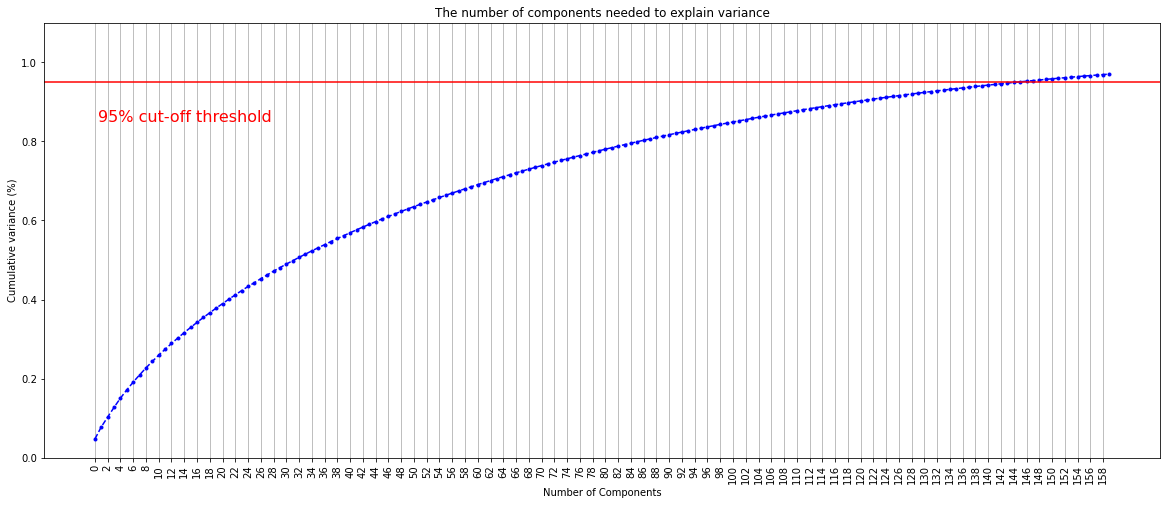

In [106]:
fig, ax = plt.subplots(figsize=(20,8))
xi = np.arange(0, 160, step=1)
y = np.cumsum(pca.explained_variance_ratio_[0:160:1])

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='.', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 160, step=2), rotation=90) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

It looks like n_components = 145 is suitable for% 95 total explained variance,

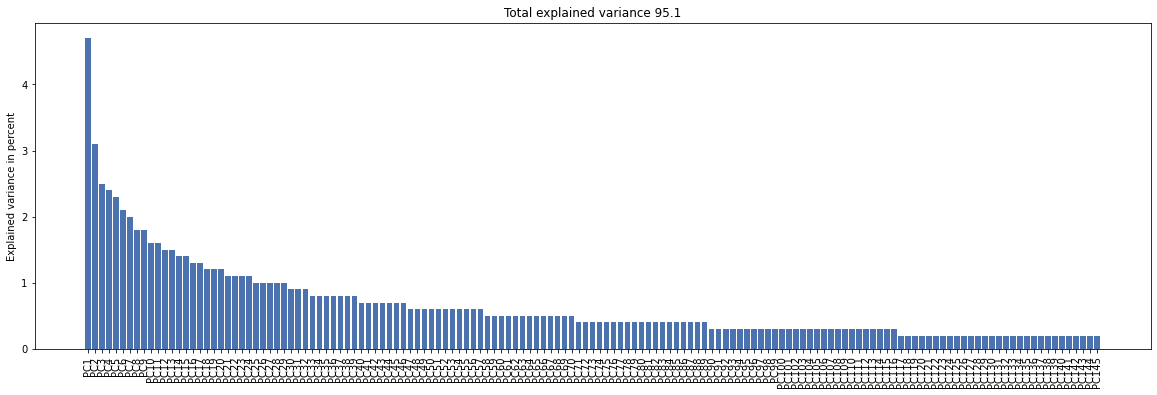

In [107]:
pca = PCA(n_components=145)
pca.fit(X_train_os)
per_var = np.round(pca.explained_variance_ratio_ * 100, 1)
labels = ['PC' + str(x) for x in range(1,len(per_var)+1)]

plt.figure(figsize=(20,6))
plt.bar(x=range(len(per_var)), height=per_var, tick_label=labels)
plt.title('Total explained variance {}'.format(np.round(sum(per_var),2)))
plt.ylabel('Explained variance in percent')
plt.xticks(rotation=90)
plt.show()

In [108]:
X_train_os_pca = pca.transform(X_train_os)
pd.DataFrame(X_train_os_pca)

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,2.84,-0.74,-0.61,0.02,-0.77,-1.80,1.20,1.36,2.90,0.07,...,-0.64,0.56,-0.45,0.77,-0.62,1.09,-0.63,-1.99,0.35,-0.46
1,-0.75,-0.42,1.66,-3.33,0.81,-0.86,2.53,-0.56,-0.11,1.63,...,0.21,-0.59,-0.59,0.32,-0.32,-0.85,-0.23,0.02,0.00,0.61
2,1.75,2.56,0.93,-2.33,-2.20,1.12,1.91,-1.09,-0.68,0.62,...,1.11,-0.47,-0.16,-0.64,0.07,0.47,1.65,0.39,1.11,-0.94
3,0.16,0.11,1.32,0.43,-1.28,-0.36,-0.68,-0.05,-0.58,-0.32,...,0.87,0.93,-1.06,0.11,-0.14,0.13,-0.01,0.44,0.76,-0.97
4,-2.89,2.48,0.50,-1.88,0.39,-0.44,-0.36,-0.38,-1.07,-0.89,...,-0.05,-0.40,-0.03,-0.16,1.79,-0.16,-0.05,-0.39,0.94,-0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,-2.27,-1.68,-1.17,-1.22,-1.69,2.14,-0.92,-0.82,-1.26,0.90,...,0.17,-0.02,-0.13,0.20,0.23,0.02,-0.27,-0.01,-0.27,0.06
2190,2.97,-5.10,1.01,-1.22,1.69,1.45,1.87,1.71,-1.43,1.38,...,-0.09,0.36,-0.46,0.50,-0.04,0.31,0.11,0.11,0.04,-0.28
2191,-2.46,1.30,0.38,-0.04,1.51,-1.65,0.60,1.83,0.63,1.47,...,0.12,0.07,0.04,0.05,0.04,0.15,-0.17,0.10,-0.08,0.11
2192,5.41,-0.16,-3.89,3.29,-1.52,-1.83,-1.79,-0.04,-0.08,-2.35,...,0.06,-0.10,0.13,-0.21,0.10,0.06,0.15,0.08,-0.04,-0.21


The loads (loading scores) indicate "how high a variable X loads on a factor Y". 

(The i-th principal components can be selected via i in pca.components_ [0].)

In [109]:
# Top 20 columns that have the greatest impact
loading_scores = pd.Series(pca.components_[0], index=X.columns)
loading_scores.abs().sort_values(ascending=False)[:20]

79    0.24
103   0.23
59    0.22
78    0.20
28    0.20
132   0.19
510   0.19
542   0.17
38    0.16
64    0.16
63    0.15
25    0.14
95    0.13
548   0.13
247   0.12
170   0.12
129   0.12
255   0.12
29    0.12
80    0.12
dtype: float64

#### Use Algorithm

In [110]:
X_test_pca = pca.transform(X_test)

In [111]:
cv_acc_balance_pca = {}
cv_TPR_balance_pca = {}
cv_FPR_balance_pca = {}

In [112]:
def plot_result_smoted_pca(model, name:str):
    model.fit(X_train_os_pca, y_train_os)
    y_pred = model.predict(X_test_pca)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores = cross_val_score(model, X_test_pca, y_test, cv=10, scoring = 'balanced_accuracy')
    cv_acc_balance_pca[name] = round(scores.mean(), 4)*100  # balanced accuracy
    cv_TPR_balance_pca[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (max)
    cv_FPR_balance_pca[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (min)
    print('Average Balanced Accuracy (CV=10):', scores.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot confusion matrix
    plt.figure(figsize=(3,3))
    plot_confusion_matrix(model, X_test_pca, y_test)
    plt.show()

Average Balanced Accuracy (CV=10): 0.4876876876876877
              precision    recall  f1-score   support

          -1       0.92      0.66      0.77       366
           1       0.04      0.19      0.06        26

    accuracy                           0.63       392
   macro avg       0.48      0.43      0.42       392
weighted avg       0.86      0.63      0.72       392



<Figure size 216x216 with 0 Axes>

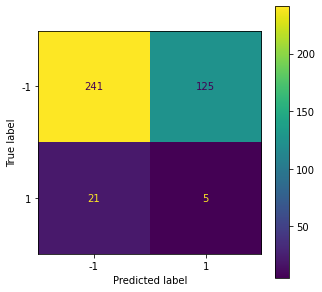

In [113]:
# Decision tree
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)

plot_result_smoted_pca(dtc, "dtc")

Average Balanced Accuracy (CV=10): 0.5145645645645647
              precision    recall  f1-score   support

          -1       0.94      0.85      0.89       366
           1       0.10      0.23      0.14        26

    accuracy                           0.81       392
   macro avg       0.52      0.54      0.52       392
weighted avg       0.88      0.81      0.84       392



<Figure size 216x216 with 0 Axes>

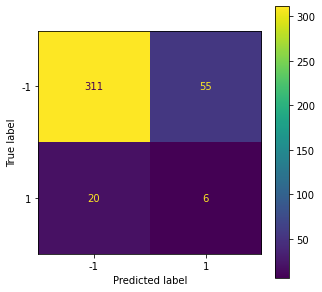

In [114]:
# Logistic Regression
lr = LogisticRegression(max_iter=200)
plot_result_smoted_pca(lr, "lr")

Average Balanced Accuracy (CV=10): 0.5
              precision    recall  f1-score   support

          -1       0.93      0.99      0.96       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



<Figure size 216x216 with 0 Axes>

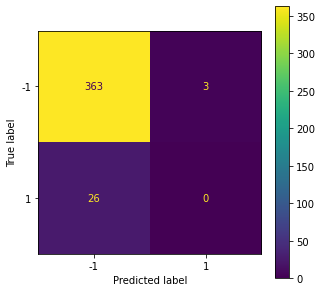

In [115]:
# SVC
svc = SVC(C=1.0, kernel='rbf', gamma='scale')  # default Werte
plot_result_smoted_pca(svc, "svc")

Average Balanced Accuracy (CV=10): 0.5
              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



<Figure size 216x216 with 0 Axes>

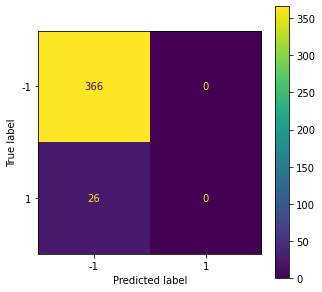

In [116]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None)
plot_result_smoted_pca(rfc, "rfc")

Average Balanced Accuracy (CV=10): 0.47702702702702704
              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



<Figure size 216x216 with 0 Axes>

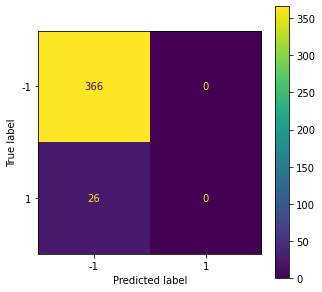

In [117]:
# Gradient Boost
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=3, random_state=42)
plot_result_smoted_pca(gbc, "gbc")

Average Balanced Accuracy (CV=10): 0.5045795795795796
              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



<Figure size 216x216 with 0 Axes>

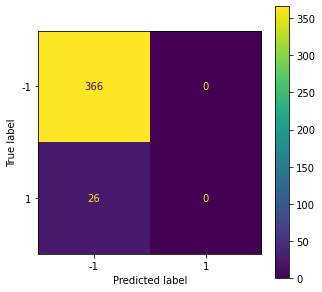

In [118]:
# Naive Bayes
nb = GaussianNB()
plot_result_smoted_pca(nb, "nb")

Average Balanced Accuracy (CV=10): 0.5278903903903904
              precision    recall  f1-score   support

          -1       0.97      0.43      0.59       366
           1       0.09      0.81      0.16        26

    accuracy                           0.45       392
   macro avg       0.53      0.62      0.38       392
weighted avg       0.91      0.45      0.56       392



<Figure size 216x216 with 0 Axes>

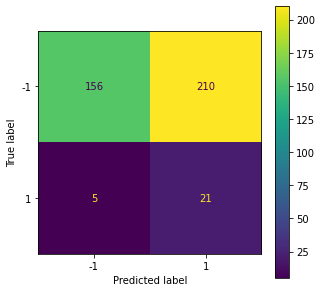

In [119]:
# kNN
knn = KNeighborsClassifier(n_neighbors=3)
plot_result_smoted_pca(knn, "knn")

Average Balanced Accuracy (CV=10): 0.49324324324324326
              precision    recall  f1-score   support

          -1       0.93      0.90      0.92       366
           1       0.05      0.08      0.06        26

    accuracy                           0.84       392
   macro avg       0.49      0.49      0.49       392
weighted avg       0.87      0.84      0.86       392



<Figure size 216x216 with 0 Axes>

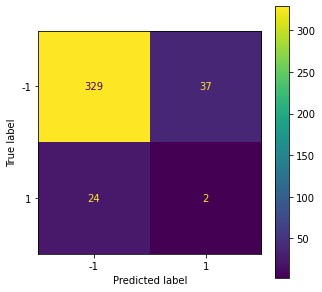

In [120]:
# XGBOOST
xgb = XGBClassifier(eval_metric = "logloss",n_estimators=25, learning_rate=0.01,  max_depth=3, random_state=42)
plot_result_smoted_pca(xgb, "xgb");

In [121]:
df_eval_smote_pca = pd.DataFrame(data={'model': list(cv_acc_balance.keys()), 'bal_acc': list(cv_acc_balance.values()), 'recall': list(cv_TPR_balance.values()), 'fallout':list(cv_FPR_balance.values())})
df_eval_smote_pca

,model,bal_acc,recall,fallout
0,dtc,60.03,42.31,11.20
1,lr,50.59,19.23,15.30
2,svc,50.00,0.00,0.55
3,rfc,50.00,0.00,0.27
4,gbc,63.36,19.23,4.10
5,nb,58.27,76.92,51.37
6,knn,54.46,80.77,67.76
7,xgb,51.25,30.77,9.56


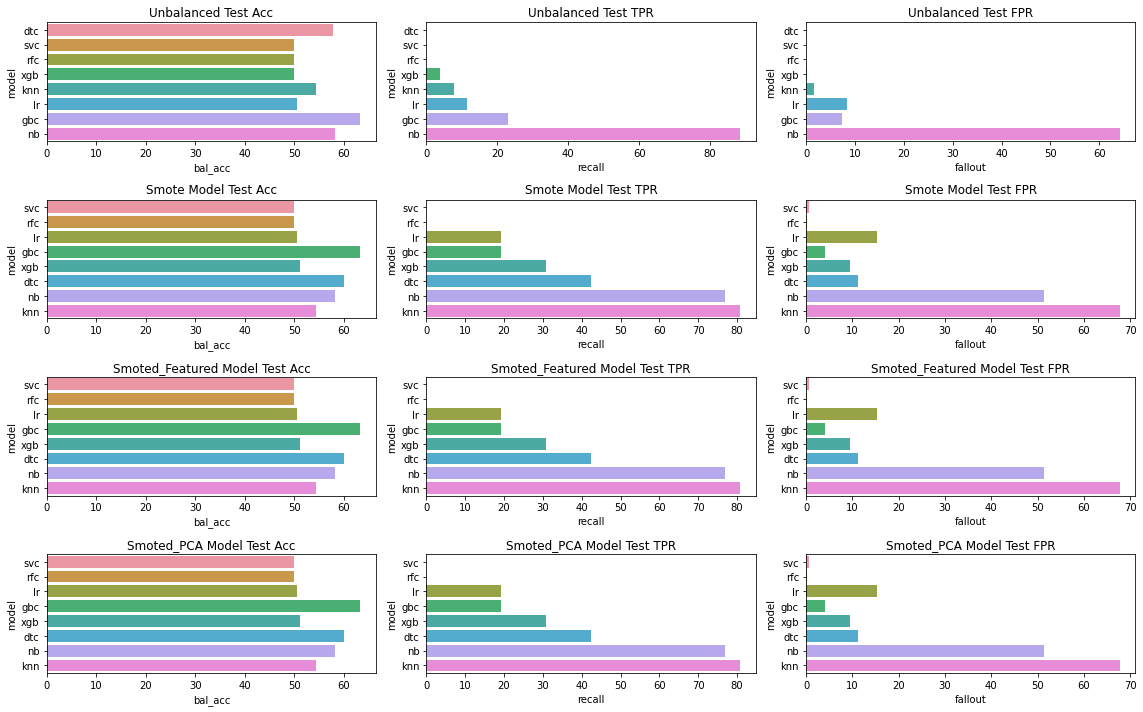

In [122]:
fig, ax = plt.subplots(4,3, figsize=(16, 10))

sns.barplot(x="bal_acc", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,0])
ax[0,0].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,1])
ax[0,1].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,2])
ax[0,2].set_title("Unbalanced Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,0])
ax[1,0].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,1])
ax[1,1].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,2])
ax[1,2].set_title("Smote Model Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,0])
ax[2,0].set_title("Smoted_Featured Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,1])
ax[2,1].set_title("Smoted_Featured Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,2])
ax[2,2].set_title("Smoted_Featured Model Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,0])
ax[3,0].set_title("Smoted_PCA Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,1])
ax[3,1].set_title("Smoted_PCA Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,2])
ax[3,2].set_title("Smoted_PCA Model Test FPR")

plt.tight_layout()
plt.show()

According to Smote and PCA, none of the models really gave relatively good results.

In [123]:
df_eval["type"] = "Unbalanced"
df_eval_smote["type"] = "Smote"
df_eval_smote_fe["type"] = "Smote_FE"
df_eval_smote_pca["type"] = "Smote_PCA"

In [124]:
frames = [df_eval, df_eval_smote, df_eval_smote_fe, df_eval_smote_pca]
df_result = pd.concat(frames, ignore_index=True)
df_result['model'] = df_result['model'].str.upper()
df_result[["recall", "fallout", "bal_acc"]] = df_result[["recall", "fallout", "bal_acc"]].apply(lambda x: np.round(x, 2))

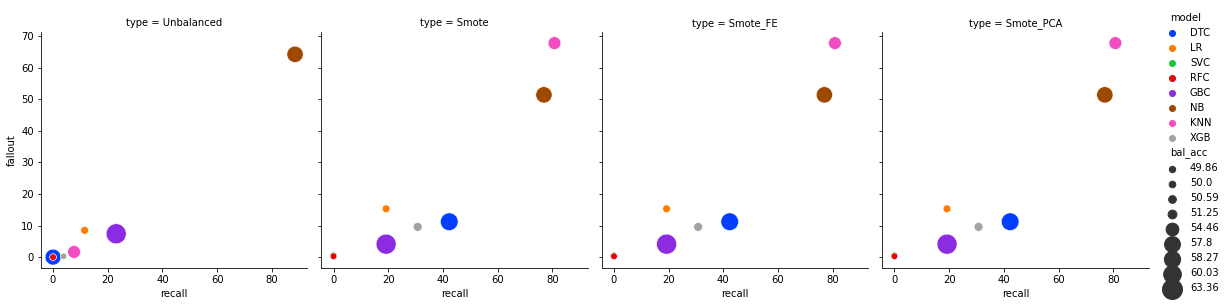

In [125]:
sns.relplot(x="recall", y="fallout", hue="model", size="bal_acc", sizes=(40, 400), col="type", alpha=1, palette="bright", height=4, legend='full', data=df_result)

In this plot it looks like GradientBoosting in Smote has a better result

## Iteration 5: (with SMOTE_FE and hyperparameter optimization)

Smote_FE looks better than Smote_PCA. Hyperparameter is optimized by Smote_FE.

#### GridSearch

In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [127]:
X_train_os_selected_filter

,1,32,2,19,180,161,188,164,27,59,...,151,89,150,78,79,146,85,86,143,102
0,-0.35,-0.24,-0.52,0.12,-0.84,1.14,-1.40,-0.29,0.12,-1.44,...,0.06,1.07,-0.19,-0.08,-0.37,-0.65,-0.56,-1.32,0.45,-0.12
1,0.68,1.15,0.56,-1.75,2.19,2.87,0.15,-0.73,-1.08,0.09,...,-0.44,-0.29,0.08,-0.08,0.10,-1.29,0.67,1.04,-1.34,0.62
2,0.47,-0.94,1.33,0.05,1.43,0.01,-0.50,-0.83,-0.90,1.32,...,1.49,0.14,-0.53,-0.08,1.38,2.64,-0.56,-0.02,-1.03,-1.31
3,0.67,-0.07,-0.66,-0.08,-0.84,-0.52,0.55,-0.19,0.13,-0.62,...,-0.38,0.06,-0.66,-0.08,0.03,1.71,-0.36,0.07,1.21,-0.17
4,-0.39,0.35,0.77,1.59,-0.84,-1.12,-0.48,-0.20,0.00,-0.03,...,-0.39,0.49,1.15,-0.08,0.25,1.20,0.05,0.38,1.01,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,0.35,0.30,-0.63,-0.14,-0.29,0.77,-0.36,-0.41,-0.66,-0.31,...,-0.33,1.15,0.13,-0.08,-0.31,0.42,-0.10,-0.74,-0.59,-0.31
2190,0.07,1.05,1.31,-0.07,1.80,1.77,0.26,-0.52,1.22,-0.17,...,2.15,0.46,-1.41,-0.08,0.46,-0.38,0.14,-0.40,0.66,-0.12
2191,0.54,-0.40,-0.40,1.00,0.49,-0.56,-0.29,0.31,0.09,-0.16,...,-0.28,-0.72,0.95,-0.08,-1.36,1.03,-0.64,-0.39,-1.30,-0.55
2192,-0.22,-0.91,-0.43,-0.48,-0.84,-0.78,0.50,0.32,0.05,-0.03,...,0.61,1.02,-0.95,-0.08,-0.74,1.26,-0.24,-1.41,0.54,-0.46


In [128]:
X_test_fe

,1,32,2,19,180,161,188,164,27,59,...,151,89,150,78,79,146,85,86,143,102
0,1.04,0.90,0.77,-0.53,-0.84,1.57,-0.48,-0.10,0.07,0.49,...,-0.41,-0.29,-0.80,-0.08,-0.80,0.77,-0.26,0.16,0.21,-0.06
1,-0.63,-0.17,1.87,0.90,-0.84,-0.04,0.52,1.55,0.09,2.44,...,-0.25,0.26,-0.93,-0.08,-0.12,0.43,1.49,0.35,-1.16,0.53
2,-0.99,0.60,0.55,-0.32,1.94,-0.82,-0.15,0.35,-0.47,-0.96,...,-0.42,-0.87,0.89,-0.08,1.96,-0.30,-0.26,2.80,-0.39,-0.08
3,-0.42,0.07,-1.52,2.42,-0.84,1.09,0.35,0.12,-0.78,1.68,...,-0.23,0.45,0.82,-0.08,-1.43,-1.18,-2.83,-0.13,-1.32,-0.16
4,0.14,-1.12,-1.22,-0.24,0.57,-0.65,-1.55,-0.41,-0.21,-1.32,...,3.04,1.07,0.08,-0.08,0.23,-0.99,0.57,-0.76,0.85,-0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,1.03,0.03,-0.00,-0.22,1.88,1.18,0.55,-0.32,0.27,-0.25,...,-0.39,-1.05,-0.33,-0.08,-0.16,-0.28,2.83,0.85,-1.03,-0.01
388,1.84,1.09,-0.51,0.19,-0.84,-0.68,-0.54,-0.52,0.13,-0.64,...,-0.48,0.45,-0.53,-0.08,-0.06,-0.31,-0.26,-0.94,-0.41,-0.63
389,-2.49,-0.50,0.60,-0.04,0.59,1.62,-0.55,0.85,-1.72,-0.39,...,0.30,0.26,-0.46,-0.08,-0.14,0.08,0.77,-0.83,0.10,-0.68
390,0.66,-0.90,-0.60,0.10,1.57,-0.54,-1.22,-0.36,-0.01,-0.76,...,-0.16,-0.60,1.02,-0.08,0.60,-0.78,-2.93,0.24,-0.87,0.20


In [129]:
# grid_searcher = GridSearchCV(svc, params, cv = 10, n_jobs=-1)
# grid_searcher.fit(X,y)

#### Use Algorithm

In [130]:
cv_acc_balance_fe_tuned = {}
cv_TPR_balance_fe_tuned = {}
cv_FPR_balance_fe_tuned = {}

In [131]:
def plot_result_smoted_fe_tuned(model, name:str):
    model.fit(X_train_os_selected_filter, y_train_os)
    y_pred = model.predict(X_test_fe)

    # Evaluation based on a 10-fold cross-validation
    scores = cross_val_score(model, X_test_fe, y_test, cv=10, scoring = 'balanced_accuracy')
    cv_acc_balance_fe_tuned[name] = round(scores.mean(), 4)*100  # balanced accuracy
    cv_TPR_balance_fe_tuned[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (max)
    cv_FPR_balance_fe_tuned[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (min)
    print('Average Balanced Accuracy (CV=10):', scores.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot confusion matrix
    plt.figure(figsize=(3,3))
    plot_confusion_matrix(model, X_test_fe, y_test)
    plt.show()

In [132]:
# Decision Tree
params = {'criterion' : ["gini", "entropy"],
          'max_depth':[2, 3, 4, 5, 10], 
          'min_samples_leaf':[100, 50, 10, 1],
          'min_samples_split':[2, 4, 8, 16]}

grid_searcher = GridSearchCV(DecisionTreeClassifier(), params)
grid_searcher.fit(X_train_os_selected_filter, y_train_os)
#plot_result_smoted_fe_tuned(grid_searcher, "dtc")

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 10],
                         'min_samples_leaf': [100, 50, 10, 1],
                         'min_samples_split': [2, 4, 8, 16]})

In [133]:
grid_searcher.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [134]:
grid_searcher.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10)

Average Balanced Accuracy (CV=10): 0.5379504504504504
              precision    recall  f1-score   support

          -1       0.93      0.84      0.89       366
           1       0.06      0.15      0.09        26

    accuracy                           0.80       392
   macro avg       0.50      0.50      0.49       392
weighted avg       0.88      0.80      0.83       392



<Figure size 216x216 with 0 Axes>

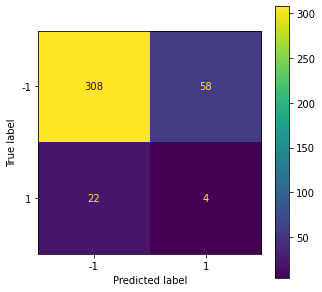

In [135]:
plot_result_smoted_fe_tuned(grid_searcher.best_estimator_, "dtc")

LogisticRegression(C=78.47599703514607, max_iter=200, penalty='l1',
                   solver='liblinear')
Average Balanced Accuracy (CV=10): 0.5687687687687688
              precision    recall  f1-score   support

          -1       0.94      0.85      0.89       366
           1       0.10      0.23      0.14        26

    accuracy                           0.81       392
   macro avg       0.52      0.54      0.52       392
weighted avg       0.88      0.81      0.84       392



<Figure size 216x216 with 0 Axes>

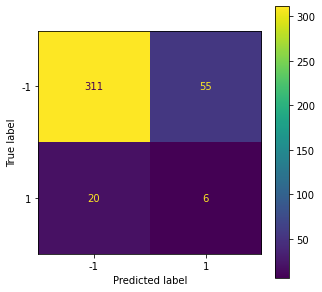

In [136]:
# Logistic Regression
params = {'penalty' : ['l1', 'l2'],
          'C' : np.logspace(-4, 4, 20),
          'max_iter':[200, 300],
          'solver' : ['liblinear']}

grid_searcher = GridSearchCV(LogisticRegression(), params)
grid_searcher.fit(X_train_os_selected_filter, y_train_os)

print(grid_searcher.best_estimator_)
plot_result_smoted_fe_tuned(grid_searcher.best_estimator_, "lr")

SVC(C=1, gamma=0.01)
Average Balanced Accuracy (CV=10): 0.5
              precision    recall  f1-score   support

          -1       0.93      0.99      0.96       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



<Figure size 216x216 with 0 Axes>

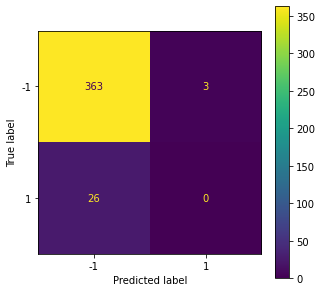

In [137]:
# SVC
params = {'kernel':(['linear','rbf']), 
          'C':[0.001, 0.01, 0.1, 1, 10, 100], 
          'gamma':[0.001, 0.01, 0.1, 1]}

grid_searcher = GridSearchCV(SVC(), params)
grid_searcher.fit(X_train_os_selected_filter, y_train_os)

print(grid_searcher.best_estimator_)
plot_result_smoted_fe_tuned(grid_searcher.best_estimator_, "svc")

RandomForestClassifier(max_features=6)
Average Balanced Accuracy (CV=10): 0.5
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



<Figure size 216x216 with 0 Axes>

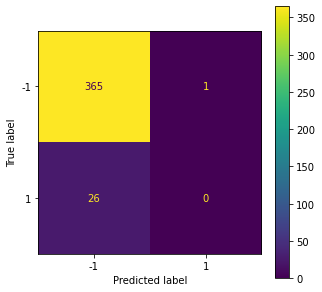

In [138]:
# Random Forest
params={'criterion': ['entropy', 'gini'],
        'n_estimators' : list(range(10,101,10)),
        'max_features' : list(range(6,32,5))}

grid_searcher = GridSearchCV(RandomForestClassifier(), params)
grid_searcher.fit(X_train_os_selected_filter, y_train_os)

print(grid_searcher.best_estimator_)
plot_result_smoted_fe_tuned(grid_searcher.best_estimator_, "rfc")

Average Balanced Accuracy (CV=10): 0.5865990990990991
              precision    recall  f1-score   support

          -1       0.93      0.98      0.96       366
           1       0.11      0.04      0.06        26

    accuracy                           0.92       392
   macro avg       0.52      0.51      0.51       392
weighted avg       0.88      0.92      0.90       392



<Figure size 216x216 with 0 Axes>

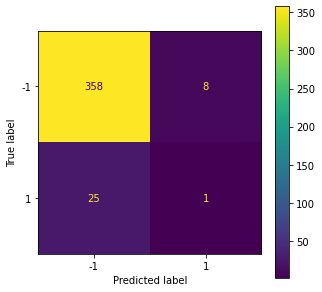

In [139]:
# These parameters could not be optimized with GridSearch because it took longer than intended. 
# Then new Parameter manual was tried again

# params={
#        "learning_rate": [1],
#       "min_samples_split": [50, 10, 2],
#        "min_samples_leaf": [1, 5, 10],
#        "max_depth":[3,4,5],
#        "subsample":[0.5, 1.0],
#        "n_estimators":[10, 50, 100],
#        "random_state":[42]}

gbc = GradientBoostingClassifier(learning_rate=1, max_depth=6, n_estimators=40, random_state=42)  # manually selected parameters
# grid_searcher = GridSearchCV(GradientBoostingClassifier(), params)
# grid_searcher.fit(X_train_os_selected_filter, y_train_os)

# print(grid_searcher.best_estimator_)
plot_result_smoted_fe_tuned(gbc, "gbc")

Average Balanced Accuracy (CV=10): 0.629954954954955
              precision    recall  f1-score   support

          -1       0.95      0.81      0.88       366
           1       0.14      0.42      0.21        26

    accuracy                           0.79       392
   macro avg       0.55      0.62      0.54       392
weighted avg       0.90      0.79      0.83       392



<Figure size 216x216 with 0 Axes>

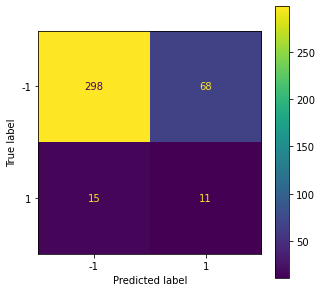

In [140]:
# Naive Bayes has no tuning
nb = GaussianNB()
plot_result_smoted_fe_tuned(nb, "nb")

KNeighborsClassifier(n_neighbors=2)
Average Balanced Accuracy (CV=10): 0.4972597597597598
              precision    recall  f1-score   support

          -1       0.98      0.58      0.73       366
           1       0.12      0.81      0.21        26

    accuracy                           0.59       392
   macro avg       0.55      0.69      0.47       392
weighted avg       0.92      0.59      0.69       392



<Figure size 216x216 with 0 Axes>

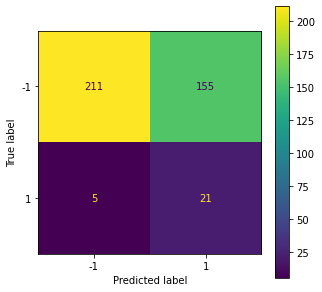

In [141]:
# kNN
params = {'n_neighbors':[2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
         'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_searcher = GridSearchCV(KNeighborsClassifier(), params)
grid_searcher.fit(X_train_os_selected_filter, y_train_os)

print(grid_searcher.best_estimator_)
plot_result_smoted_fe_tuned(grid_searcher.best_estimator_, "knn")

Average Balanced Accuracy (CV=10): 0.5070945945945946
              precision    recall  f1-score   support

          -1       0.95      0.90      0.93       366
           1       0.19      0.31      0.23        26

    accuracy                           0.86       392
   macro avg       0.57      0.61      0.58       392
weighted avg       0.90      0.86      0.88       392



<Figure size 216x216 with 0 Axes>

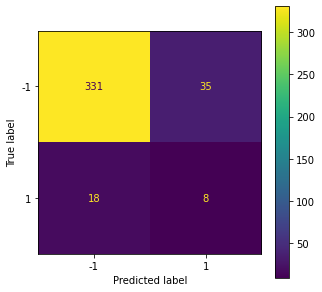

In [142]:
# XGBOOST
xgb = XGBClassifier(eval_metric = "logloss",n_estimators=25, learning_rate=0.01,  max_depth=3, random_state=42)
plot_result_smoted_fe_tuned(xgb, "xgb");

In [143]:
df_eval_smote_fe_tuned = pd.DataFrame(data={'model': list(cv_acc_balance.keys()), 'bal_acc': list(cv_acc_balance.values()), 'recall': list(cv_TPR_balance.values()), 'fallout':list(cv_FPR_balance.values())})
df_eval_smote_fe_tuned

,model,bal_acc,recall,fallout
0,dtc,60.03,42.31,11.20
1,lr,50.59,19.23,15.30
2,svc,50.00,0.00,0.55
3,rfc,50.00,0.00,0.27
4,gbc,63.36,19.23,4.10
5,nb,58.27,76.92,51.37
6,knn,54.46,80.77,67.76
7,xgb,51.25,30.77,9.56


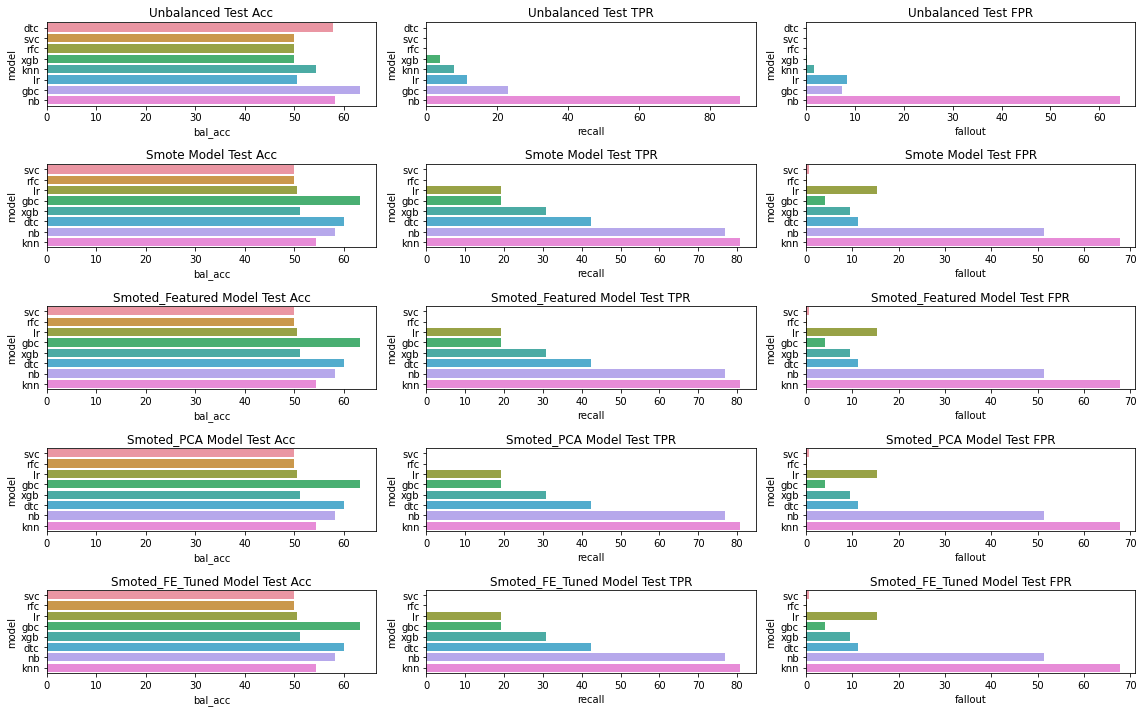

In [144]:
fig, ax = plt.subplots(5,3, figsize=(16, 10))

sns.barplot(x="bal_acc", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,0])
ax[0,0].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,1])
ax[0,1].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,2])
ax[0,2].set_title("Unbalanced Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,0])
ax[1,0].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,1])
ax[1,1].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,2])
ax[1,2].set_title("Smote Model Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,0])
ax[2,0].set_title("Smoted_Featured Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,1])
ax[2,1].set_title("Smoted_Featured Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,2])
ax[2,2].set_title("Smoted_Featured Model Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,0])
ax[3,0].set_title("Smoted_PCA Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,1])
ax[3,1].set_title("Smoted_PCA Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,2])
ax[3,2].set_title("Smoted_PCA Model Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote_fe_tuned.sort_values(by="recall"), ax=ax[4,0])
ax[4,0].set_title("Smoted_FE_Tuned Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_fe_tuned.sort_values(by="recall"), ax=ax[4,1])
ax[4,1].set_title("Smoted_FE_Tuned Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_fe_tuned.sort_values(by="recall"), ax=ax[4,2])
ax[4,2].set_title("Smoted_FE_Tuned Model Test FPR")

plt.tight_layout()
plt.show()

In [145]:
df_eval_smote_fe_tuned["type"] = "Smote_FE_Tuned"

In [146]:
frames = [df_eval, df_eval_smote, df_eval_smote_fe, df_eval_smote_pca, df_eval_smote_fe_tuned]
df_result = pd.concat(frames, ignore_index=True)
df_result['model'] = df_result['model'].str.upper()
df_result[["recall", "fallout", "bal_acc"]] = df_result[["recall", "fallout", "bal_acc"]].apply(lambda x: np.round(x, 2))
df_result

,model,bal_acc,recall,fallout,type
0,DTC,57.80,0.00,0.00,Unbalanced
1,LR,50.59,11.54,8.47,Unbalanced
2,SVC,50.00,0.00,0.00,Unbalanced
3,RFC,50.00,0.00,0.00,Unbalanced
4,GBC,63.36,23.08,7.38,Unbalanced
5,NB,58.27,88.46,64.21,Unbalanced
6,KNN,54.46,7.69,1.64,Unbalanced
7,XGB,49.86,3.85,0.27,Unbalanced
8,DTC,60.03,42.31,11.20,Smote
9,LR,50.59,19.23,15.30,Smote


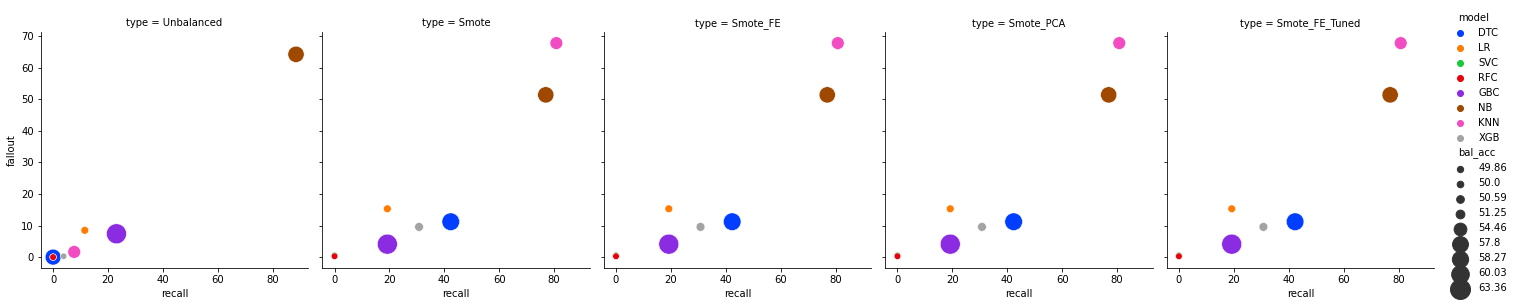

In [147]:
sns.relplot(x="recall", y="fallout", hue="model", size="bal_acc", sizes=(40, 400), col="type", alpha=1, palette="bright", height=4, legend='full', data=df_result)

#### Summary: 
In this project the SECOM dataset was analyzed by machine learning methods with 5 iterations as a classification. For each iteration one tried little by little to achieve a better model result. Therefore 7 different algorithms (DecisionTree, Logistic Regression, Support Vector Machine, Random Forest, Gradient Boost, NaiveBayes and kNearestNeigbour) were used. After the data cleaning and EDA process, the data set was scaled with StandartScaler because there were many large and small features. After that, something special (oversampling, FeatureSelection, FeatureExtraction, HyperParameter optimization) was applied in each iteration. In the end, GradientBoost with only oversampled and scaled data set gave better results. The outliers can be checked for the next iteration and for each column one should decide whether 1.5xquarter is the correct limit for the real outliers.  

## THE END. THANK YOU FOR YOUR ATTENTION.

## Extra section: Handling outliers

In [148]:
data

,0,1,2,3,4,6,7,8,9,10,...,565,570,571,572,582,583,586,587,589,Pass_Fail
0,3030.93,2564.00,2187.73,1411.13,1.36,97.61,0.12,1.50,0.02,-0.00,...,0.62,533.85,2.11,8.95,0.50,0.01,0.01,0.02,208.20,-1
1,3095.78,2465.14,2230.42,1463.66,0.83,102.34,0.12,1.50,-0.00,-0.01,...,0.62,535.02,2.43,5.92,0.50,0.02,0.01,0.02,208.20,-1
2,2932.61,2559.94,2186.41,1698.02,1.51,95.49,0.12,1.44,0.00,0.00,...,0.62,535.02,2.03,11.21,0.50,0.02,0.06,0.05,82.86,1
3,2988.72,2479.90,2199.03,909.79,1.32,104.24,0.12,1.49,-0.01,-0.00,...,0.16,530.57,2.03,9.33,0.50,0.01,0.02,0.01,73.84,-1
4,3032.24,2502.87,2233.37,1326.52,1.53,100.40,0.12,1.50,-0.00,-0.01,...,0.16,532.02,2.03,8.83,0.48,0.48,0.02,0.01,73.84,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.73,3085.38,1.48,82.25,0.12,1.34,-0.00,-0.01,...,0.09,536.34,2.02,7.98,0.50,0.01,0.01,0.01,203.17,-1
1563,3052.31,2522.55,2198.57,1124.66,0.88,98.47,0.12,1.43,-0.01,-0.01,...,0.13,537.93,2.18,5.48,0.50,0.01,0.01,0.01,203.17,-1
1564,2978.81,2379.78,2206.30,1110.50,0.82,99.41,0.12,1.43,-0.01,-0.01,...,0.24,530.37,2.34,6.49,0.50,0.02,0.02,0.01,43.52,-1
1565,2894.92,2532.01,2177.03,1183.73,1.57,98.80,0.12,1.46,-0.01,0.00,...,0.09,534.39,1.91,9.13,0.50,0.02,0.03,0.02,93.49,-1


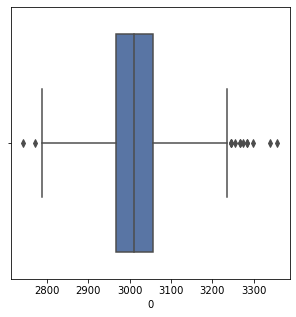

In [149]:
sns.boxplot(x=data['0'], whis=2);

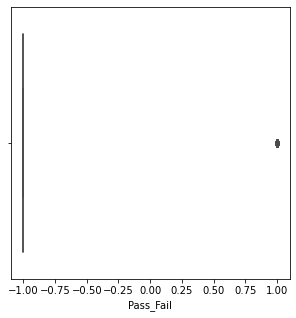

In [150]:
sns.boxplot(x=data['Pass_Fail'], whis=2);

#### z-score
The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

In [151]:
from scipy import stats

z = np.abs(stats.zscore(data))
print(z)

[[0.22566111 0.84854878 0.43824807 ... 0.41156808 1.15545812 0.26662109]
 [1.10665293 0.38276838 1.01074172 ... 0.41156808 1.15545812 0.26662109]
 [1.11002301 0.79798083 0.48312752 ... 3.62660435 0.17981004 3.75064097]
 ...
 [0.48239276 1.44594087 0.19196163 ... 0.89489542 0.59886042 0.26662109]
 [1.62204432 0.4501082  0.80143828 ... 0.91143238 0.06652919 0.26662109]
 [0.9427908  0.56187359 0.17651012 ... 0.03149345 0.40528665 0.26662109]]


In [152]:
z[0][1]

0.8485487769934856

In [153]:
threshold = 3
print(np.where(z > 3))

(array([   0,    0,    0, ..., 1565, 1565, 1566], dtype=int64), array([ 65,  75, 147, ...,  62, 150,   3], dtype=int64))


The first array contains the list of row numbers and second array respective column numbers, which means a Z-score higher than 3.

In [154]:
print(z[0][82])  # So, the data point — 0th record on column 82 is an outlier.

0.23591466957103707


In [155]:
data_o = data[(z < 3).all(axis=1)]

In [156]:
data_o.shape

(344, 205)

Our record rose to 267 lines

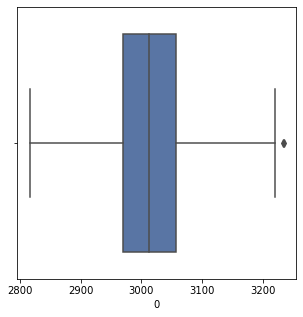

In [157]:
sns.boxplot(x=data_o['0'], whis=2);

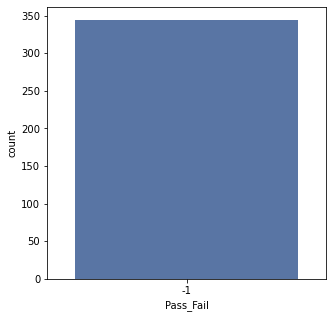

In [158]:
sns.countplot(data_o.Pass_Fail);

All 1 values have been deleted, so you have to work with X again

In [159]:
X = data.drop('Pass_Fail', axis=1)
y = data['Pass_Fail']

In [160]:
from scipy import stats

z = np.abs(stats.zscore(X))
print(z)

[[0.22566111 0.84854878 0.43824807 ... 0.95927966 0.41156808 1.15545812]
 [1.10665293 0.38276838 1.01074172 ... 0.95927966 0.41156808 1.15545812]
 [1.11002301 0.79798083 0.48312752 ... 2.99088442 3.62660435 0.17981004]
 ...
 [0.48239276 1.44594087 0.19196163 ... 0.14172521 0.89489542 0.59886042]
 [1.62204432 0.4501082  0.80143828 ... 0.38442369 0.91143238 0.06652919]
 [0.9427908  0.56187359 0.17651012 ... 0.78929309 0.03149345 0.40528665]]


In [161]:
X_o = X[(z < 3).all(axis=1)]
X_o.shape

(365, 204)

In [162]:
X_o.index

Int64Index([   6,   18,   22,   45,   49,   71,  105,  108,  122,  124,
            ...
            1507, 1510, 1515, 1516, 1531, 1538, 1546, 1548, 1561, 1564],
           dtype='int64', length=365)

In [163]:
y_o = y.iloc[X_o.index]

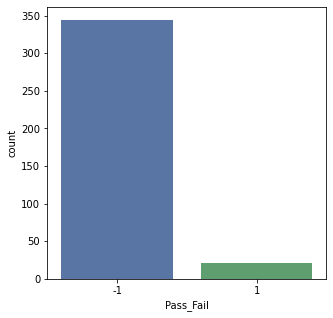

In [164]:
sns.countplot(y_o);

##### IQR Score

In [165]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

0      90.22
1      86.49
2      37.01
3     508.59
4       0.51
       ...  
582     0.00
583     0.00
586     0.01
587     0.01
589    70.38
Length: 204, dtype: float64


In [166]:
((X < (Q1 - 2 * IQR)) | (X > (Q3 + 2 * IQR)))

,0,1,2,3,4,6,7,8,9,10,...,564,565,570,571,572,582,583,586,587,589
0,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,False,False,False,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1563,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1564,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1565,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [167]:
X_out = X[~((X < (Q1 - 2.5 * IQR)) | (X > (Q3 + 2.5 * IQR))).any(axis=1)]
X_out.shape

(137, 204)

In [168]:
X_out

,0,1,2,3,4,6,7,8,9,10,...,564,565,570,571,572,582,583,586,587,589
41,3017.10,2517.18,2180.38,1208.74,1.30,100.28,0.12,1.47,-0.00,0.01,...,3.48,0.19,531.38,2.47,6.59,0.50,0.01,0.02,0.02,73.88
162,2892.37,2517.09,2184.88,960.85,1.02,102.53,0.12,1.46,0.01,-0.01,...,1.79,0.16,535.16,2.29,5.72,0.51,0.01,0.02,0.01,47.08
164,2999.01,2447.29,2217.76,1349.35,1.28,105.31,0.12,1.56,-0.01,0.00,...,4.40,0.08,534.50,2.42,10.13,0.50,0.01,0.01,0.01,143.33
190,3024.74,2553.60,2171.81,1007.24,1.46,104.74,0.13,1.50,-0.01,0.01,...,4.94,0.09,533.82,2.10,8.14,0.50,0.01,0.01,0.02,170.46
200,2896.63,2550.51,2165.62,953.00,1.34,105.94,0.12,1.43,0.01,-0.01,...,3.71,0.10,533.92,2.13,7.87,0.50,0.01,0.01,0.01,76.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,3093.24,2488.18,2212.84,1068.56,1.78,113.88,0.12,1.35,0.01,0.01,...,8.19,0.14,530.37,2.34,6.49,0.50,0.02,0.01,0.01,105.71
1547,3008.77,2542.36,2167.42,2837.88,1.49,83.82,0.13,1.29,0.00,-0.00,...,4.98,0.09,532.16,2.14,7.11,0.50,0.02,0.02,0.01,36.30
1554,3031.78,2528.55,2182.56,1261.09,1.21,112.29,0.13,1.35,0.02,0.00,...,4.98,0.09,537.93,2.18,5.48,0.50,0.01,0.02,0.03,117.09
1561,2951.14,2326.59,2212.63,1081.57,1.01,113.43,0.13,1.45,-0.01,0.01,...,4.98,0.09,527.94,2.39,9.69,0.50,0.01,0.03,0.01,46.46


You could get 137 lines with just 2.5 whiskers. This number of records will not be enough. 

#### Then data scaled with z_score are processed further.

##### The data is split using the train_test_split function.

In [169]:
# the function train_test_split creates random data samples (default: 75-25%)
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_o, y_o, stratify=y_o, random_state=42)  # seed for comparable results

In [170]:
X_train_o.shape

(273, 204)

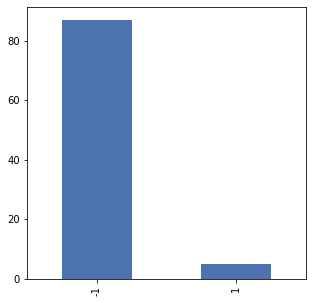

In [171]:
y_test_o.value_counts().plot.bar();

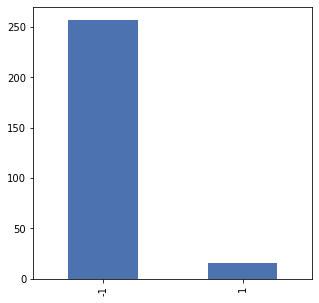

In [172]:
y_train_o.value_counts().plot.bar();

### Scaling Data

In [173]:
from sklearn.preprocessing import StandardScaler

In [174]:
std_scale = StandardScaler().fit(X_train_o)
X_train_o_scaled = std_scale.transform(X_train_o)
pd.DataFrame(X_train_o_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
0,0.21,0.59,1.39,1.58,0.56,-0.55,0.15,0.41,-0.25,-0.03,...,-0.75,0.25,-0.15,1.04,-0.09,-1.50,0.10,0.23,-0.98,-0.82
1,1.98,-0.38,0.56,-0.38,-1.28,0.68,0.36,0.15,-0.21,1.09,...,-0.86,-0.30,0.12,0.18,-0.05,0.26,0.76,1.16,-0.46,-0.81
2,2.14,-0.07,-0.52,-1.17,0.06,0.54,-1.08,-1.63,2.09,-1.02,...,-0.55,-0.72,-0.38,-0.35,-0.03,1.09,0.08,-0.61,-0.88,-0.42
3,0.96,-1.02,-0.40,-0.23,0.18,0.80,0.84,-0.48,0.39,0.96,...,0.27,0.25,0.98,1.21,-0.21,-1.47,0.80,0.44,-0.48,-0.64
4,0.68,-0.24,-1.08,-0.93,-1.41,0.03,-0.12,-1.50,-0.44,1.28,...,0.51,-0.28,-1.48,2.12,-0.04,-0.12,-0.94,0.01,-1.45,-1.00


In [175]:
X_test_o_scaled = std_scale.transform(X_test_o)
pd.DataFrame(X_test_o_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
0,0.35,0.04,-2.78,-0.54,-1.26,-0.10,1.64,-1.35,2.24,0.01,...,-1.45,0.05,-0.25,0.95,-0.07,-0.92,-0.03,-0.35,-0.21,-0.13
1,-0.62,-0.94,0.63,0.63,-1.28,-0.59,-0.81,-0.57,-0.66,1.02,...,-0.55,-0.72,0.75,0.08,-0.14,-0.61,-0.94,-1.22,-0.85,0.29
2,0.66,0.27,-0.24,0.59,-0.15,-0.65,1.11,0.96,0.65,0.65,...,-0.94,0.74,0.17,1.19,-0.05,-0.06,-1.10,-0.94,1.07,1.72
3,-0.79,-1.75,-1.37,0.16,0.99,0.63,1.59,-0.01,-2.10,-0.26,...,-0.43,-0.53,0.17,0.60,-0.01,1.00,-0.85,-0.61,-0.77,-0.33
4,-0.58,0.21,1.98,0.97,-0.27,0.04,-1.40,0.38,-0.34,0.43,...,1.21,0.13,-0.38,-0.35,-0.03,1.98,-0.81,-0.82,-0.72,-0.11


#### SMOTE

In [176]:
from imblearn.over_sampling import SMOTE

In [177]:
oversmote = SMOTE()
X_train_os, y_train_os= oversmote.fit_resample(X_train_o_scaled, y_train_o)

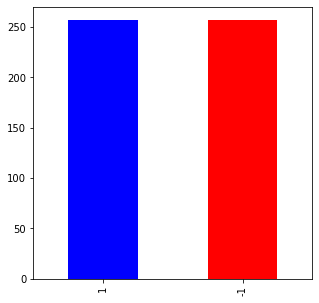

In [178]:
y_train_os.value_counts().plot.bar(color=["blue", "red"])
plt.show()

In [179]:
X_train_os.shape

(514, 204)

### Use Algorithm

In [180]:
cv_acc_balance_o = {}
cv_TPR_balance_o = {}
cv_FPR_balance_o = {}

In [181]:
def plot_result_smote_o(model, name:str):
    model.fit(X_train_os, y_train_os)
    y_pred = model.predict(X_test_o_scaled)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores = cross_val_score(model, X_test_o_scaled, y_test_o, cv=10, scoring = 'balanced_accuracy')
    cv_acc_balance_o[name] = round(scores.mean(), 4)*100  # balanced accuracy
    cv_TPR_balance_o[name] = (confusion_matrix(y_test_o, y_pred)[1][1]/confusion_matrix(y_test_o, y_pred)[1].sum())*100  # recall (max)
    cv_FPR_balance_o[name] = (confusion_matrix(y_test_o, y_pred)[0][1]/confusion_matrix(y_test_o, y_pred)[0].sum())*100  # fallout (min)
    print('Aerage Balanced Accuracy (CV=10):', scores.mean())

    # print classification report
    print(classification_report(y_test_o, y_pred, zero_division=0))

    # Plot Confusion matrix
    plot_confusion_matrix(model, X_test_o_scaled, y_test_o)
    plt.show()

Aerage Balanced Accuracy (CV=10): 0.7152777777777778
              precision    recall  f1-score   support

          -1       0.94      0.76      0.84        87
           1       0.05      0.20      0.07         5

    accuracy                           0.73        92
   macro avg       0.49      0.48      0.46        92
weighted avg       0.89      0.73      0.80        92



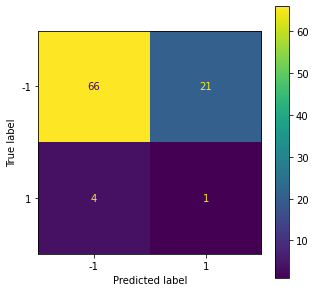

In [182]:
# Decision Tree
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)

plot_result_smote_o(dtc, "dtc")

Aerage Balanced Accuracy (CV=10): 0.75
              precision    recall  f1-score   support

          -1       0.94      0.95      0.95        87
           1       0.00      0.00      0.00         5

    accuracy                           0.90        92
   macro avg       0.47      0.48      0.47        92
weighted avg       0.89      0.90      0.90        92



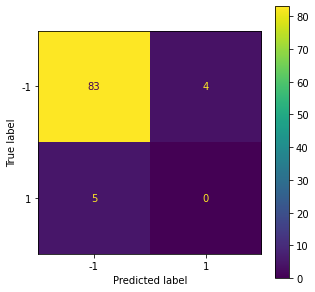

In [183]:
# Logistic Regression
lr = LogisticRegression(max_iter=200)
plot_result_smote_o(lr, "lr")

Aerage Balanced Accuracy (CV=10): 0.75
              precision    recall  f1-score   support

          -1       0.95      1.00      0.97        87
           1       0.00      0.00      0.00         5

    accuracy                           0.95        92
   macro avg       0.47      0.50      0.49        92
weighted avg       0.89      0.95      0.92        92



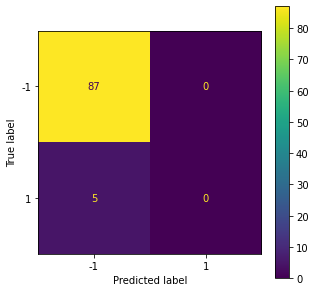

In [184]:
# SVC
svc = SVC(C=1.0, kernel='rbf', gamma='scale')  # default Werte
plot_result_smote_o(svc, "svc")

Aerage Balanced Accuracy (CV=10): 0.75
              precision    recall  f1-score   support

          -1       0.95      1.00      0.97        87
           1       0.00      0.00      0.00         5

    accuracy                           0.95        92
   macro avg       0.47      0.50      0.49        92
weighted avg       0.89      0.95      0.92        92



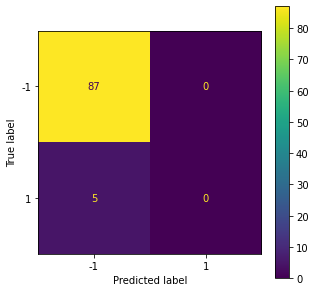

In [185]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None)
plot_result_smote_o(rfc, "rfc")

Aerage Balanced Accuracy (CV=10): 0.75
              precision    recall  f1-score   support

          -1       0.95      0.99      0.97        87
           1       0.00      0.00      0.00         5

    accuracy                           0.93        92
   macro avg       0.47      0.49      0.48        92
weighted avg       0.89      0.93      0.91        92



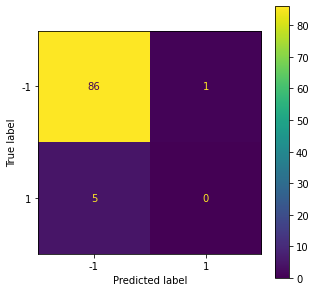

In [186]:
# Gradient Boost
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=3, random_state=42)
plot_result_smote_o(gbc, "gbc")

Aerage Balanced Accuracy (CV=10): 0.75
              precision    recall  f1-score   support

          -1       0.95      1.00      0.97        87
           1       0.00      0.00      0.00         5

    accuracy                           0.95        92
   macro avg       0.47      0.50      0.49        92
weighted avg       0.89      0.95      0.92        92



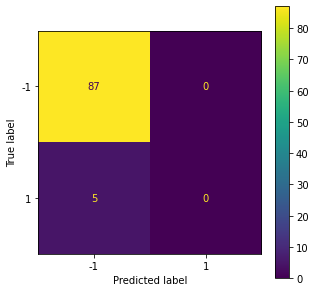

In [187]:
# Naive Bayes
nb = GaussianNB()
plot_result_smote_o(nb, "nb")

Aerage Balanced Accuracy (CV=10): 0.68125
              precision    recall  f1-score   support

          -1       0.93      0.16      0.27        87
           1       0.05      0.80      0.10         5

    accuracy                           0.20        92
   macro avg       0.49      0.48      0.19        92
weighted avg       0.89      0.20      0.26        92



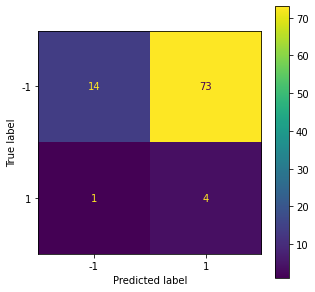

In [188]:
# kNN
knn = KNeighborsClassifier(n_neighbors=3)
plot_result_smote_o(knn, "knn")

Aerage Balanced Accuracy (CV=10): 0.75
              precision    recall  f1-score   support

          -1       0.95      0.80      0.87        87
           1       0.06      0.20      0.09         5

    accuracy                           0.77        92
   macro avg       0.50      0.50      0.48        92
weighted avg       0.90      0.77      0.83        92



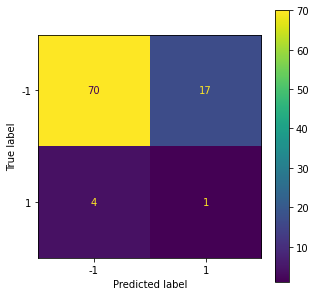

In [189]:
# XGBOOST
xgb = XGBClassifier(eval_metric = "logloss",n_estimators=25, learning_rate=0.01,  max_depth=3, random_state=42)
plot_result_smote_o(xgb, "xgb");

In [190]:
df_eval_smote_o = pd.DataFrame(data={'model': list(cv_acc_balance.keys()), 'bal_acc': list(cv_acc_balance.values()), 'recall': list(cv_TPR_balance.values()), 'fallout':list(cv_FPR_balance.values())})
df_eval_smote_o

,model,bal_acc,recall,fallout
0,dtc,60.03,42.31,11.20
1,lr,50.59,19.23,15.30
2,svc,50.00,0.00,0.55
3,rfc,50.00,0.00,0.27
4,gbc,63.36,19.23,4.10
5,nb,58.27,76.92,51.37
6,knn,54.46,80.77,67.76
7,xgb,51.25,30.77,9.56


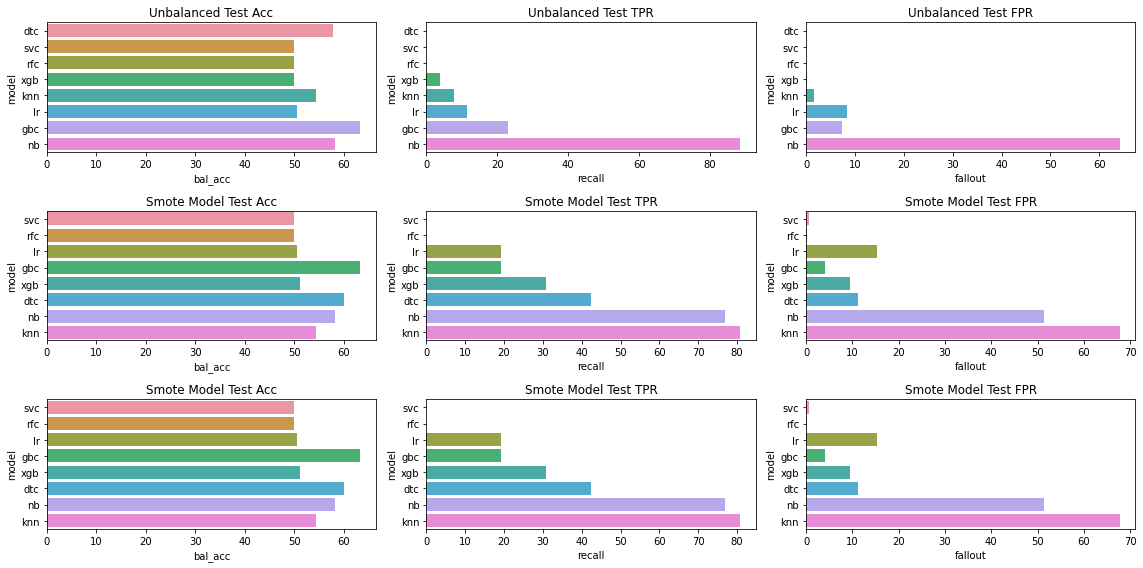

In [191]:
fig, ax = plt.subplots(3,3, figsize=(16, 8))
sns.barplot(x="bal_acc", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,0])
ax[0,0].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,1])
ax[0,1].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,2])
ax[0,2].set_title("Unbalanced Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,0])
ax[1,0].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,1])
ax[1,1].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,2])
ax[1,2].set_title("Smote Model Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote_o.sort_values(by="recall"), ax=ax[2,0])
ax[2,0].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_o.sort_values(by="recall"), ax=ax[2,1])
ax[2,1].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_o.sort_values(by="recall"), ax=ax[2,2])
ax[2,2].set_title("Smote Model Test FPR")

plt.tight_layout()
plt.show()

SVC looks good, less FPR and large TPR with relatively good balance accuracy

### Many Thanks.